In [1]:
import connectorx as cx
import pandas as pd
import numpy as np
import os
import duckdb
from datetime import datetime
import glob
import multiprocessing as mp
from functools import partial
import time

In [2]:
raw_path = "/data/home/lexuanchen/Factors/Order/Signal/Six_Times_Divergence/Test/bid_main_1000_1430.parquet"
std_path = "/data/home/lexuanchen/Factors/Order/Signal/Six_Times_Divergence/Test/noind_debug_signal_neut.parquet"
hl_raw_path = "/data/home/lexuanchen/Factors/Order/Signal/Six_Times_Divergence/Test/hl_bid_main_1000_1430.parquet"
hl_std_path = "/data/home/lexuanchen/Factors/Order/Signal/Six_Times_Divergence/Test/hl_debug_signal_neut.parquet"

raw_factor = pd.read_parquet(raw_path)
std_factor = pd.read_parquet(std_path)
hl_raw_factor = pd.read_parquet(hl_raw_path)
hl_std_factor = pd.read_parquet(hl_std_path)

In [3]:
# 检查数据框的列名
print("raw_factor 的列名:")
print(raw_factor.columns.tolist())
print("\nhl_raw_factor 的列名:")
print(hl_raw_factor.columns.tolist())
print("std_factor 的列名:")
print(std_factor.columns.tolist())
print("\nhl_std_raw_factor 的列名:")
print(hl_std_factor.columns.tolist())

raw_factor 的列名:
['sigdate', 'secu_code', 'alpha_raw']

hl_raw_factor 的列名:
['sigdate', 'secu_code', 'alpha_raw']
std_factor 的列名:
['sigdate', 'secu_code', 'alpha_neut_std']

hl_std_raw_factor 的列名:
['sigdate', 'secu_code', 'alpha_neut_std']


In [4]:
hl_raw_factor = hl_raw_factor.rename(columns={'alpha_raw': 'hl_bid_main_1000_1430','sigdate':'date','secu_code':'security_code'})
hl_std_factor = hl_std_factor.rename(columns={'alpha_neut_std': 'hl_bid_main_1000_1430_std','sigdate':'date','secu_code':'security_code'})
raw_factor = raw_factor.rename(columns={'alpha_raw': 'bid_main_1000_1430','sigdate':'date','secu_code':'security_code'})
std_factor = std_factor.rename(columns={'alpha_neut_std': 'bid_main_1000_1430_std','sigdate':'date','secu_code':'security_code'})

In [5]:
hl_raw_factor['date'] = hl_raw_factor['date'].astype(str)
hl_std_factor['date'] = hl_std_factor['date'].astype(str)
raw_factor['date'] = raw_factor['date'].astype(str)
std_factor['date'] = std_factor['date'].astype(str)

In [9]:
def set_chinese_font():
    """设置中文字体"""
    from matplotlib.font_manager import FontProperties
    
    # 使用指定的字体文件
    font_path = '/tmp/ChineseFont.ttf'
    chinese_font = FontProperties(fname=font_path)
    
    # 定义辅助函数
    def zh_title(text):
        """使用中文字体设置标题"""
        plt.title(text, fontproperties=chinese_font)
    
    def zh_xlabel(text):
        """使用中文字体设置x轴标签"""
        plt.xlabel(text, fontproperties=chinese_font)
    
    def zh_ylabel(text):
        """使用中文字体设置y轴标签"""
        plt.ylabel(text, fontproperties=chinese_font)
    
    def zh_text(x, y, text):
            return plt.text(x, y, text, fontproperties=chinese_font)
    
    def zh_legend(*args, **kwargs):
        """使用中文字体设置图例"""
        if 'prop' not in kwargs:
            kwargs['prop'] = chinese_font
        return plt.legend(*args, **kwargs)
    
    return zh_title, zh_xlabel, zh_ylabel, zh_text,zh_legend


zh_title, zh_xlabel, zh_ylabel, zh_text, zh_legend = set_chinese_font()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# 1. 分析原始因子与涨跌停处理后因子的相关性
def analyze_factor_correlation(raw_factor, hl_raw_factor):
    """分析原始因子与涨跌停处理后因子的相关性"""
    # 合并两个因子数据
    merged = pd.merge(
        raw_factor[['date', 'security_code', 'bid_main_1000_1430']], 
        hl_raw_factor[['date', 'security_code', 'hl_bid_main_1000_1430']], 
        on=['date', 'security_code'], 
        how='inner'
    )
    
    # 计算每日相关性
    daily_corr = []
    for date in merged['date'].unique():
        date_data = merged[merged['date'] == date]
        if len(date_data) > 30:  # 确保有足够的数据点
            corr, _ = spearmanr(date_data['bid_main_1000_1430'], date_data['hl_bid_main_1000_1430'])
            daily_corr.append({'date': date, 'correlation': corr})
    
    daily_corr_df = pd.DataFrame(daily_corr)
    
    # 计算整体相关性
    overall_corr, _ = spearmanr(merged['bid_main_1000_1430'], merged['hl_bid_main_1000_1430'])
    
    print(f"原始因子与涨跌停处理后因子的整体Spearman相关性: {overall_corr:.4f}")
    print(f"日均相关性: {daily_corr_df['correlation'].mean():.4f}")
    
    # 绘制日相关性变化图
    plt.figure(figsize=(12, 6))
    plt.plot(daily_corr_df['date'], daily_corr_df['correlation'])
    plt.axhline(y=overall_corr, color='r', linestyle='--', label=f'整体相关性: {overall_corr:.4f}')
    zh_title('原始因子与涨跌停处理后因子的日相关性变化')
    zh_xlabel('日期')
    zh_ylabel('Spearman相关性')
    plt.grid(True)
    zh_legend()
    plt.tight_layout()
    
    return daily_corr_df

# 2. 分析分组变化情况
def analyze_group_changes(std_factor, hl_std_factor, n_groups=10):
    """分析标准化后的因子分组变化情况"""
    # 合并标准化后的因子数据
    merged = pd.merge(
        std_factor[['date', 'security_code', 'bid_main_1000_1430_std']], 
        hl_std_factor[['date', 'security_code', 'hl_bid_main_1000_1430_std']], 
        on=['date', 'security_code'], 
        how='inner'
    )
    
    # 按日期分组计算
    consistency_by_date = []
    overlap_by_date = []
    
    for date in merged['date'].unique():
        date_data = merged[merged['date'] == date].copy()
        
        # 为原始因子和处理后因子分别计算分组
        date_data['raw_group'] = pd.qcut(date_data['bid_main_1000_1430_std'], n_groups, labels=False, duplicates='drop')
        date_data['hl_group'] = pd.qcut(date_data['hl_bid_main_1000_1430_std'], n_groups, labels=False, duplicates='drop')
        
        # 计算每个分组的一致性
        group_consistency = {}
        for i in range(n_groups):
            raw_stocks = set(date_data[date_data['raw_group'] == i]['security_code'])
            hl_stocks = set(date_data[date_data['hl_group'] == i]['security_code'])
            
            if len(raw_stocks) > 0 and len(hl_stocks) > 0:
                overlap = len(raw_stocks.intersection(hl_stocks))
                consistency = overlap / len(raw_stocks)
                group_consistency[i] = consistency
        
        # 特别关注多头组(第9组，索引为n_groups-1)的重叠情况
        raw_top_stocks = set(date_data[date_data['raw_group'] == n_groups-1]['security_code'])
        hl_top_stocks = set(date_data[date_data['hl_group'] == n_groups-1]['security_code'])
        
        if len(raw_top_stocks) > 0 and len(hl_top_stocks) > 0:
            top_overlap = len(raw_top_stocks.intersection(hl_top_stocks))
            top_overlap_rate = top_overlap / len(raw_top_stocks)
            
            overlap_by_date.append({
                'date': date,
                'top_overlap_count': top_overlap,
                'top_overlap_rate': top_overlap_rate,
                'raw_top_count': len(raw_top_stocks),
                'hl_top_count': len(hl_top_stocks)
            })
        
        consistency_by_date.append({
            'date': date,
            **{f'group_{i}_consistency': group_consistency.get(i, np.nan) for i in range(n_groups)}
        })
    
    consistency_df = pd.DataFrame(consistency_by_date)
    overlap_df = pd.DataFrame(overlap_by_date)
    
    # 计算平均一致性
    avg_consistency = {i: consistency_df[f'group_{i}_consistency'].mean() for i in range(n_groups) if f'group_{i}_consistency' in consistency_df.columns}
    
    print("各分组平均一致性:")
    for group, cons in avg_consistency.items():
        print(f"分组 {group}: {cons:.4f}")
    
    print(f"\n多头组平均重叠率: {overlap_df['top_overlap_rate'].mean():.4f}")
    
    # 绘制多头组重叠率变化图
    plt.figure(figsize=(12, 6))
    plt.plot(overlap_df['date'], overlap_df['top_overlap_rate'])
    plt.axhline(y=overlap_df['top_overlap_rate'].mean(), color='r', linestyle='--', 
                label=f'平均重叠率: {overlap_df["top_overlap_rate"].mean():.4f}')
    zh_title('多头组重叠率随时间变化')
    zh_xlabel('日期')
    zh_ylabel('重叠率')
    plt.grid(True)
    zh_legend()
    plt.tight_layout()
    
    return consistency_df, overlap_df
    
    return top_group_df

# 4. 分析因子值的分布变化
def analyze_factor_distribution(raw_factor, hl_raw_factor):
    """分析因子值的分布变化"""
    # 合并原始因子数据
    merged = pd.merge(
        raw_factor[['date', 'security_code', 'bid_main_1000_1430']], 
        hl_raw_factor[['date', 'security_code', 'hl_bid_main_1000_1430']], 
        on=['date', 'security_code'], 
        how='inner'
    )
    
    # 计算描述性统计量
    stats = {
        '原始因子': merged['bid_main_1000_1430'].describe(),
        '涨跌停处理后因子': merged['hl_bid_main_1000_1430'].describe()
    }
    
    print("原始因子描述性统计:")
    print(stats['原始因子'])
    print("\n涨跌停处理后因子描述性统计:")
    print(stats['涨跌停处理后因子'])
    
    # 绘制因子值分布图
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(merged['bid_main_1000_1430'], kde=True)
    zh_title('原始因子值分布')
    zh_xlabel('因子值')
    zh_ylabel('频率')
    
    plt.subplot(1, 2, 2)
    sns.histplot(merged['hl_bid_main_1000_1430'], kde=True)
    zh_title('涨跌停处理后因子值分布')
    zh_xlabel('因子值')
    zh_ylabel('频率')
    
    plt.tight_layout()
    
    # 绘制散点图比较原始因子和处理后因子
    plt.figure(figsize=(10, 8))
    plt.scatter(merged['bid_main_1000_1430'], merged['hl_bid_main_1000_1430'], alpha=0.5)
    zh_xlabel('原始因子值')
    zh_ylabel('涨跌停处理后因子值')
    zh_title('原始因子 vs 涨跌停处理后因子')
    plt.grid(True)
    
    # 添加对角线
    min_val = min(merged['bid_main_1000_1430'].min(), merged['hl_bid_main_1000_1430'].min())
    max_val = max(merged['bid_main_1000_1430'].max(), merged['hl_bid_main_1000_1430'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.tight_layout()
    
    # 计算每日因子值差异的统计量
    merged['diff'] = merged['hl_bid_main_1000_1430'] - merged['bid_main_1000_1430']
    
    daily_diff_stats = []
    for date in merged['date'].unique():
        date_data = merged[merged['date'] == date]
        daily_diff_stats.append({
            'date': date,
            'mean_diff': date_data['diff'].mean(),
            'abs_mean_diff': date_data['diff'].abs().mean(),
            'max_abs_diff': date_data['diff'].abs().max()
        })
    
    diff_stats_df = pd.DataFrame(daily_diff_stats)
    
    # 绘制每日平均差异变化图
    plt.figure(figsize=(12, 6))
    plt.plot(diff_stats_df['date'], diff_stats_df['abs_mean_diff'])
    plt.axhline(y=diff_stats_df['abs_mean_diff'].mean(), color='r', linestyle='--', 
                label=f'平均绝对差异: {diff_stats_df["abs_mean_diff"].mean():.6f}')
    zh_title('每日因子值平均绝对差异')
    zh_xlabel('日期')
    zh_ylabel('平均绝对差异')
    plt.grid(True)
    zh_legend()
    plt.tight_layout()
    
    # 检查极端值的变化
    percentiles = [0.01, 0.05, 0.1, 0.9, 0.95, 0.99]
    raw_percentiles = np.percentile(merged['bid_main_1000_1430'], [p*100 for p in percentiles])
    hl_percentiles = np.percentile(merged['hl_bid_main_1000_1430'], [p*100 for p in percentiles])
    
    print("\n分位数比较:")
    for i, p in enumerate(percentiles):
        print(f"{p*100}% 分位数 - 原始: {raw_percentiles[i]:.6f}, 处理后: {hl_percentiles[i]:.6f}, 差异: {hl_percentiles[i] - raw_percentiles[i]:.6f}")
    
    return stats, merged


原始因子与涨跌停处理后因子的整体Spearman相关性: 0.8811
日均相关性: 0.8829


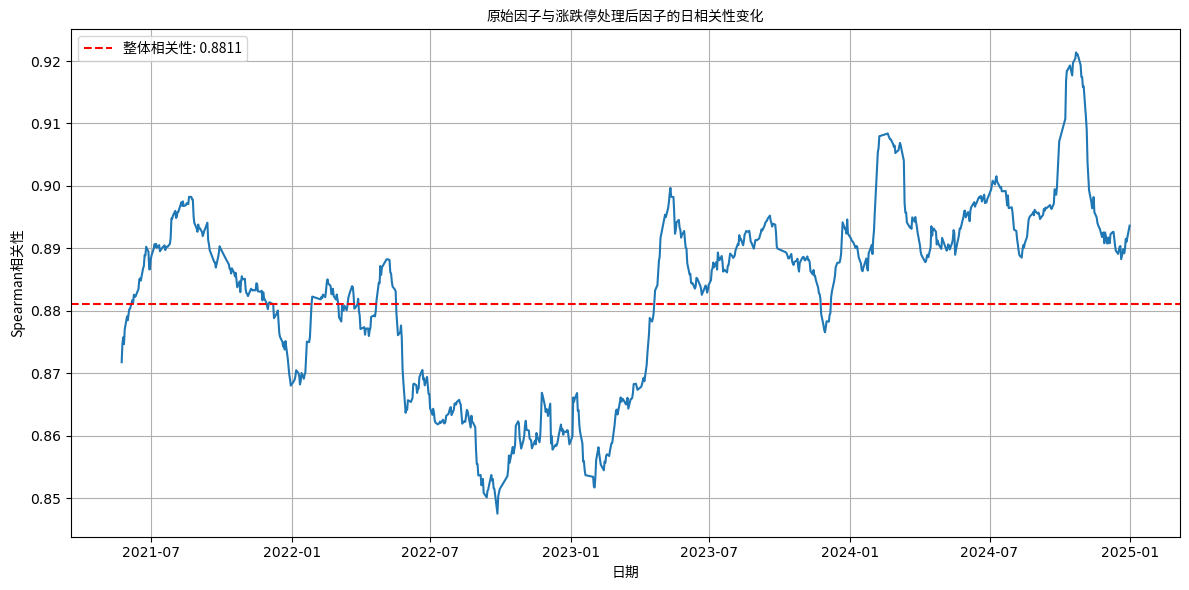

In [34]:
corr_df = analyze_factor_correlation(raw_factor, hl_raw_factor)

各分组平均一致性:
分组 0: 0.9581
分组 1: 0.9057
分组 2: 0.8435
分组 3: 0.7660
分组 4: 0.6744
分组 5: 0.5767
分组 6: 0.4796
分组 7: 0.3858
分组 8: 0.3020
分组 9: 0.3131

多头组平均重叠率: 0.3131


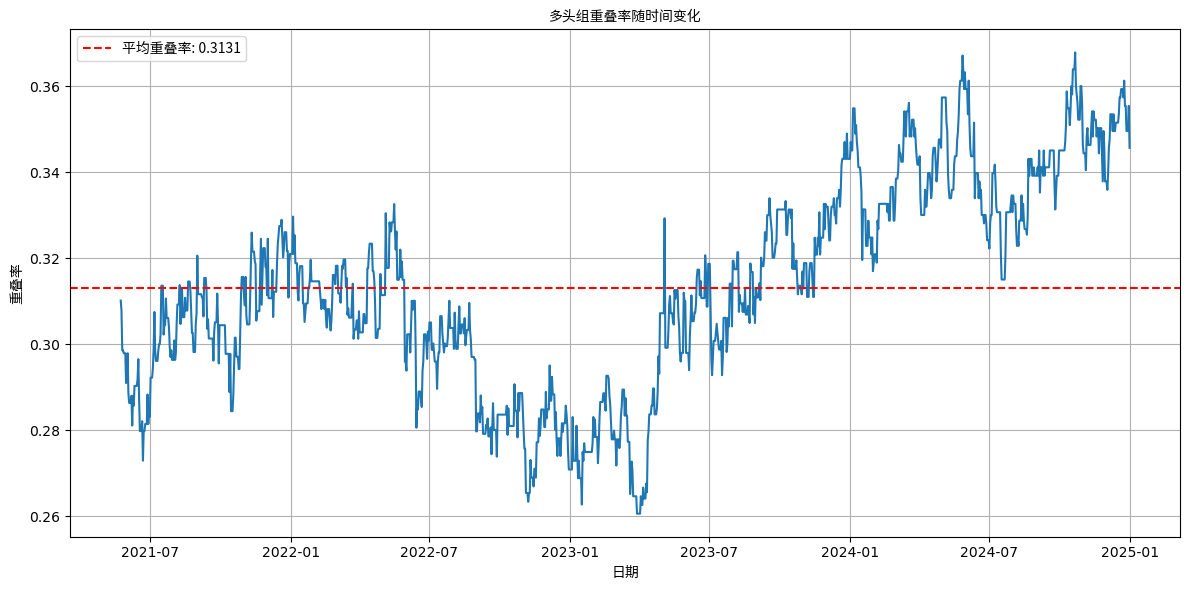

In [35]:
consistency_df, overlap_df = analyze_group_changes(std_factor, hl_std_factor)

In [66]:
def analyze_top_group_characteristics(raw_factor, hl_raw_factor, std_factor, hl_std_factor, n_groups=10, visualize=True):
    """
    分析原始因子和半衰期处理后因子的多头组特征差异
    
    参数:
    raw_factor: 原始因子数据
    hl_raw_factor: 涨跌停处理后的原始因子数据
    std_factor: 标准化后的原始因子数据
    hl_std_factor: 标准化后的半衰期处理因子数据
    n_groups: 分组数量，默认为10
    visualize: 是否生成可视化图表，默认为True
    
    返回:
    DataFrame: 包含每日多头组特征的数据框
    """
    # 确保日期列类型一致
    raw_factor['date'] = pd.to_datetime(raw_factor['date'])
    hl_raw_factor['date'] = pd.to_datetime(hl_raw_factor['date'])
    std_factor['date'] = pd.to_datetime(std_factor['date'])
    hl_std_factor['date'] = pd.to_datetime(hl_std_factor['date'])
    
    # 合并标准化因子
    merged_std = pd.merge(
        std_factor[['date', 'security_code', 'bid_main_1000_1430_std']], 
        hl_std_factor[['date', 'security_code', 'hl_bid_main_1000_1430_std']], 
        on=['date', 'security_code'], 
        how='inner'
    )
    
    # 合并原始因子
    merged_raw = pd.merge(
        raw_factor[['date', 'security_code', 'bid_main_1000_1430']], 
        hl_raw_factor[['date', 'security_code', 'hl_bid_main_1000_1430']], 
        on=['date', 'security_code'], 
        how='inner'
    )
    
    # 合并标准化和原始数据
    merged = pd.merge(merged_std, merged_raw, on=['date', 'security_code'], how='inner')
    
    # 按日期分组
    top_group_changes = []
    
    for date, group in merged.groupby('date'):
        # 按原始因子排序并获取前10%
        raw_top = group.nlargest(max(1, int(len(group) * 0.1)), 'bid_main_1000_1430_std')
        raw_top_codes = set(raw_top['security_code'])
        raw_top_avg_factor = raw_top['bid_main_1000_1430'].mean()
        
        # 按处理后因子排序并获取前10%
        hl_top = group.nlargest(max(1, int(len(group) * 0.1)), 'hl_bid_main_1000_1430_std')
        hl_top_codes = set(hl_top['security_code'])
        hl_top_avg_factor = hl_top['hl_bid_main_1000_1430'].mean()
        
        # 计算重叠股票
        overlap_codes = raw_top_codes.intersection(hl_top_codes)
        
        # 计算重叠率
        overlap_rate = len(overlap_codes) / len(raw_top_codes) if raw_top_codes else 0
        
        # 计算仅在原始多头中的股票的平均因子值
        only_in_raw_codes = raw_top_codes - hl_top_codes
        only_in_raw_avg_factor = group[group['security_code'].isin(only_in_raw_codes)]['bid_main_1000_1430'].mean() if only_in_raw_codes else np.nan
        
        # 计算仅在处理后多头中的股票的平均因子值
        only_in_hl_codes = hl_top_codes - raw_top_codes
        only_in_hl_avg_factor = group[group['security_code'].isin(only_in_hl_codes)]['hl_bid_main_1000_1430'].mean() if only_in_hl_codes else np.nan
        
        # 创建结果字典
        result_dict = {
            'date': date,
            'raw_top_avg_factor': raw_top_avg_factor,
            'hl_top_avg_factor': hl_top_avg_factor,
            'overlap_rate': overlap_rate,
            'only_in_raw_avg_factor': only_in_raw_avg_factor,
            'only_in_hl_avg_factor': only_in_hl_avg_factor
        }
        
        # 添加到结果列表
        top_group_changes.append(result_dict)
    
    # 创建DataFrame
    top_group_df = pd.DataFrame(top_group_changes)
    
    # 计算并打印关键统计数据
    print(f"多头组平均重叠率: {top_group_df['overlap_rate'].mean():.4f}")
    print(f"原始多头组平均因子值: {top_group_df['raw_top_avg_factor'].mean():.6f}")
    print(f"处理后多头组平均因子值: {top_group_df['hl_top_avg_factor'].mean():.6f}")
    
    # 可视化部分
    if visualize and not top_group_df.empty:
        plt.figure(figsize=(15, 12))
        
        # 1. 重叠率随时间变化
        plt.subplot(3, 1, 1)
        plt.plot(top_group_df['date'], top_group_df['overlap_rate'], 'b-', linewidth=1)
        plt.axhline(y=top_group_df['overlap_rate'].mean(), color='r', linestyle='--', 
                    label=f'平均: {top_group_df["overlap_rate"].mean():.4f}')
        zh_title('多头组重叠率随时间变化')
        zh_ylabel('重叠率')
        plt.grid(True, alpha=0.3)
        zh_legend()
        
        # 2. 原始和处理后多头组平均因子值对比
        plt.subplot(3, 1, 2)
        plt.plot(top_group_df['date'], top_group_df['raw_top_avg_factor'], 'g-', linewidth=1, label='原始因子')
        plt.plot(top_group_df['date'], top_group_df['hl_top_avg_factor'], 'r-', linewidth=1, label='涨跌停处理因子')
        zh_title('多头组平均因子值对比')
        zh_ylabel('因子值')
        plt.grid(True, alpha=0.3)
        zh_legend()
        
        # 3. 仅在各自多头组中的股票平均因子值对比
        plt.subplot(3, 1, 3)
        plt.plot(top_group_df['date'], top_group_df['only_in_raw_avg_factor'], 'g-', linewidth=1, label='仅在原始多头组')
        plt.plot(top_group_df['date'], top_group_df['only_in_hl_avg_factor'], 'r-', linewidth=1, label='仅在处理后多头组')
        zh_title('非重叠股票平均因子值对比')
        zh_ylabel('因子值')
        plt.grid(True, alpha=0.3)
        zh_legend()
        
        plt.tight_layout()
        plt.show()
        
        # 4. 重叠率分布直方图
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.hist(top_group_df['overlap_rate'], bins=20, color='skyblue', edgecolor='black')
        plt.axvline(x=top_group_df['overlap_rate'].mean(), color='r', linestyle='--', 
                    label=f'平均: {top_group_df["overlap_rate"].mean():.4f}')
        zh_title('多头组重叠率分布')
        zh_xlabel('重叠率')
        zh_ylabel('频次')
        plt.grid(True, alpha=0.3)
        zh_legend()
        
        # 5. 按年度/季度分组的重叠率箱线图
        plt.subplot(1, 2, 2)
        # 添加年份列
        top_group_df['year'] = top_group_df['date'].dt.year

        # 使用 matplotlib 直接绘制箱线图，而不是通过 pandas
        years = sorted(top_group_df['year'].unique())
        data_by_year = [top_group_df[top_group_df['year'] == year]['overlap_rate'].values for year in years]

        # 检查每年的数据量
        for i, year in enumerate(years):
            count = len(data_by_year[i])
            print(f"年份 {year} 的数据点数量: {count}")

        # 只绘制有足够数据的年份
        valid_years = []
        valid_data = []
        for i, year in enumerate(years):
            if len(data_by_year[i]) > 0:  # 确保有数据
                valid_years.append(year)
                valid_data.append(data_by_year[i])

        if valid_data:  # 确保有有效数据
            plt.boxplot(valid_data, labels=valid_years)
            zh_title('各年度多头组重叠率分布')
            zh_xlabel('年份')
            zh_ylabel('重叠率')
            plt.grid(True, alpha=0.3)
        else:
            zh_text(0.5, 0.5, '没有足够的数据来绘制箱线图', ha='center', va='center')
        
        plt.tight_layout()
        plt.show()
        
        # 6. 相关性分析
        plt.figure(figsize=(12, 5))
        
        # 原始因子值与处理后因子值的散点图
        plt.subplot(1, 2, 1)
        plt.scatter(top_group_df['raw_top_avg_factor'], top_group_df['hl_top_avg_factor'], alpha=0.5)
        zh_xlabel('原始多头组平均因子值')
        zh_ylabel('处理后多头组平均因子值')
        zh_title(f'因子值相关性: {top_group_df["raw_top_avg_factor"].corr(top_group_df["hl_top_avg_factor"]):.4f}')
        plt.grid(True, alpha=0.3)
        
        # 重叠率与因子值差异的散点图
        plt.subplot(1, 2, 2)
        factor_diff = abs(top_group_df['raw_top_avg_factor'] - top_group_df['hl_top_avg_factor'])
        plt.scatter(top_group_df['overlap_rate'], factor_diff, alpha=0.5)
        zh_xlabel('重叠率')
        zh_ylabel('因子值差异(绝对值)')
        zh_title(f'重叠率与因子值差异相关性: {top_group_df["overlap_rate"].corr(factor_diff):.4f}')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 7. 滚动分析
        plt.figure(figsize=(15, 7))
        
        # 计算60天滚动平均值
        window = 60
        rolling_overlap = top_group_df['overlap_rate'].rolling(window=window).mean()
        rolling_raw = top_group_df['raw_top_avg_factor'].rolling(window=window).mean()
        rolling_hl = top_group_df['hl_top_avg_factor'].rolling(window=window).mean()
        
        plt.subplot(2, 1, 1)
        plt.plot(top_group_df['date'], rolling_overlap, 'b-', linewidth=2)
        zh_title(f'{window}天滚动平均重叠率')
        zh_ylabel('重叠率')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 1, 2)
        plt.plot(top_group_df['date'], rolling_raw, 'g-', linewidth=2, label='原始因子')
        plt.plot(top_group_df['date'], rolling_hl, 'r-', linewidth=2, label='涨跌停处理因子')
        zh_title(f'{window}天滚动平均因子值')
        zh_ylabel('因子值')
        plt.grid(True, alpha=0.3)
        zh_legend()
        
        plt.tight_layout()
        plt.show()
    
    return top_group_df


多头组平均重叠率: 0.3094
原始多头组平均因子值: -0.007193
处理后多头组平均因子值: -0.001808


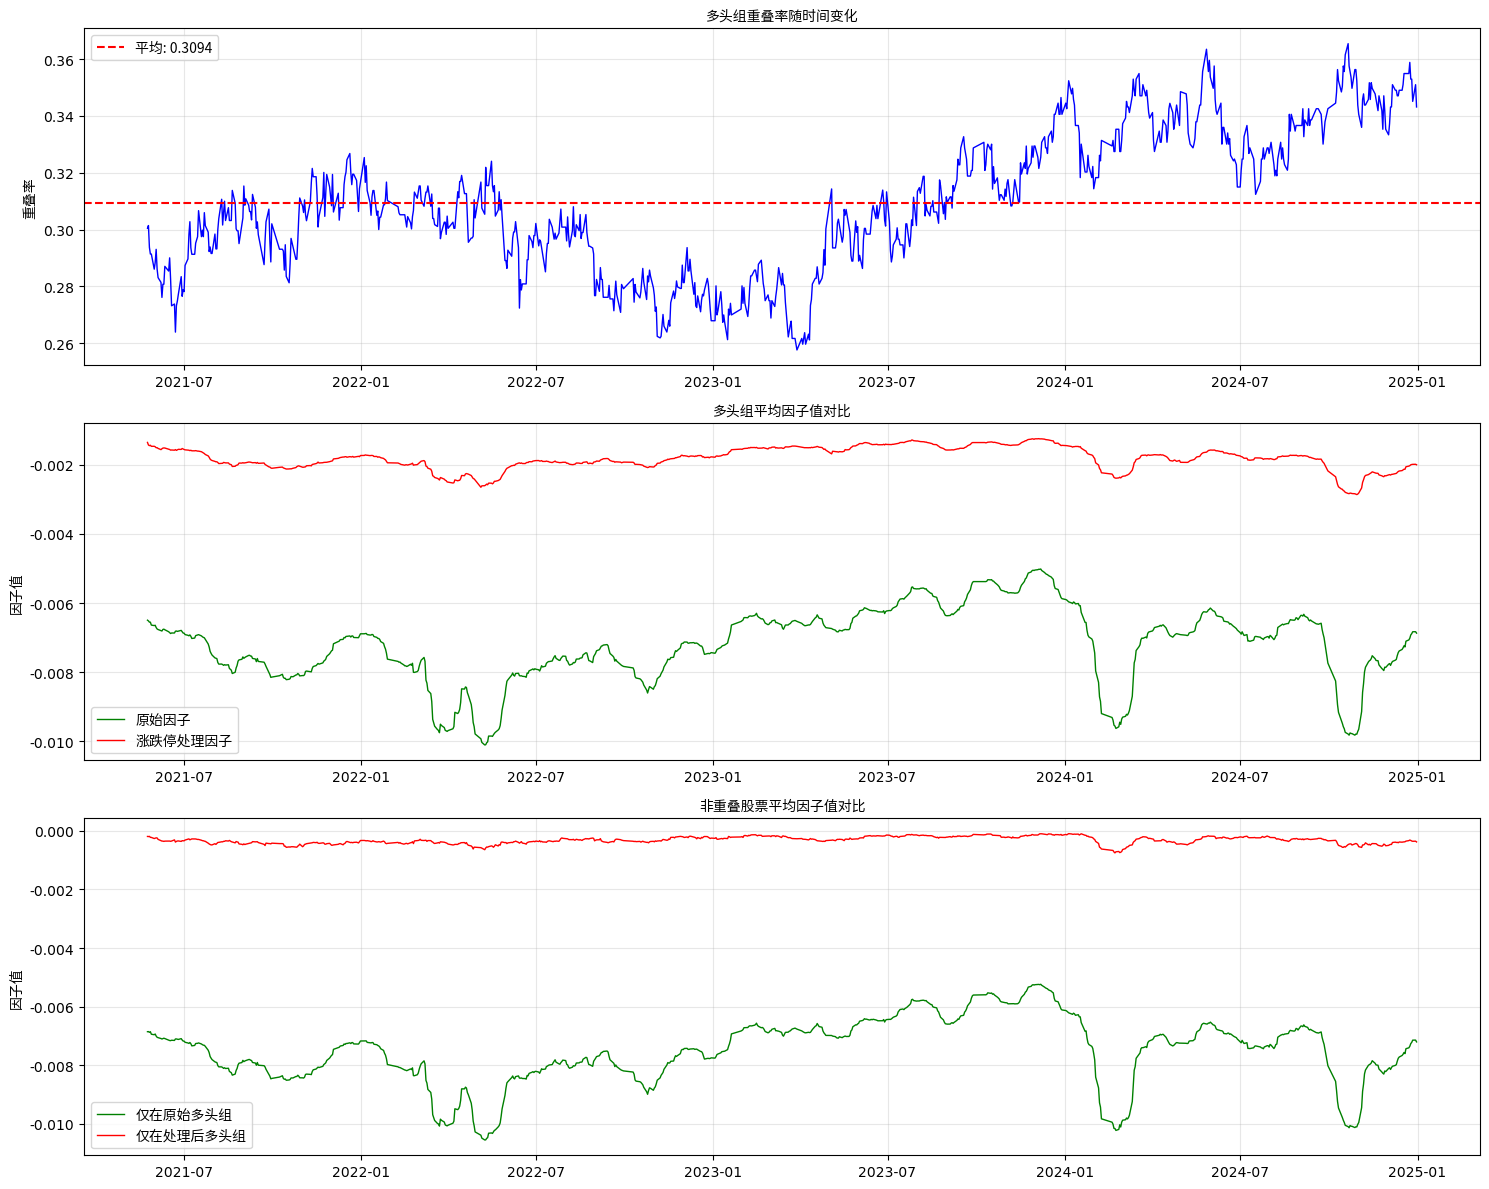

年份 2021 的数据点数量: 142
年份 2022 的数据点数量: 236
年份 2023 的数据点数量: 237
年份 2024 的数据点数量: 235


/tmp/ipykernel_2679230/3758032914.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(valid_data, labels=valid_years)


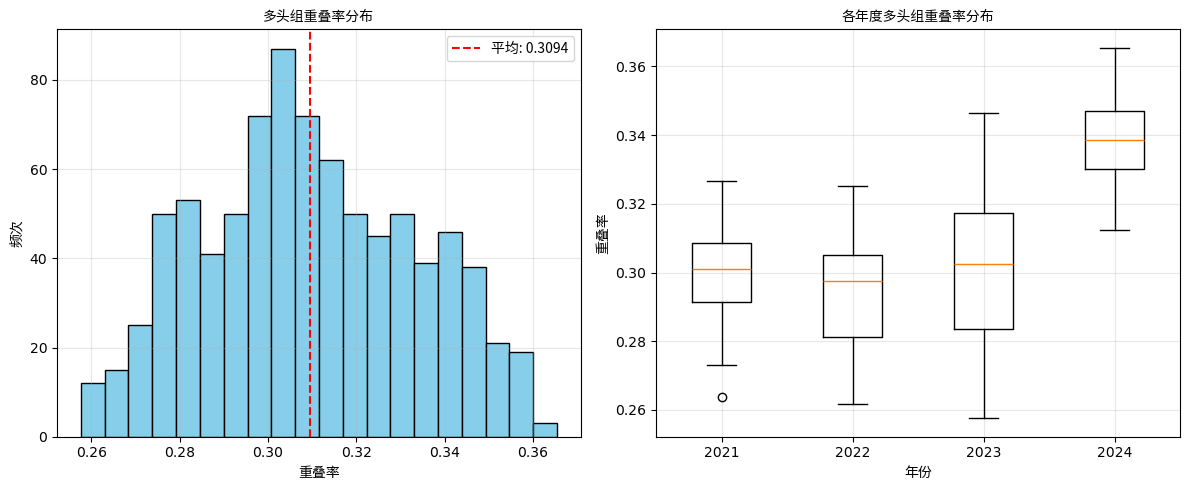

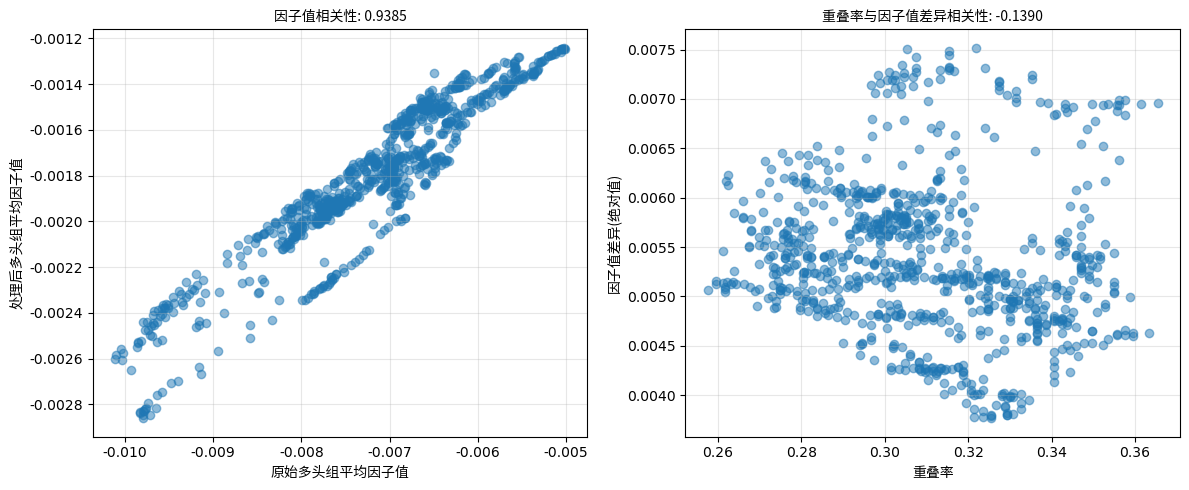

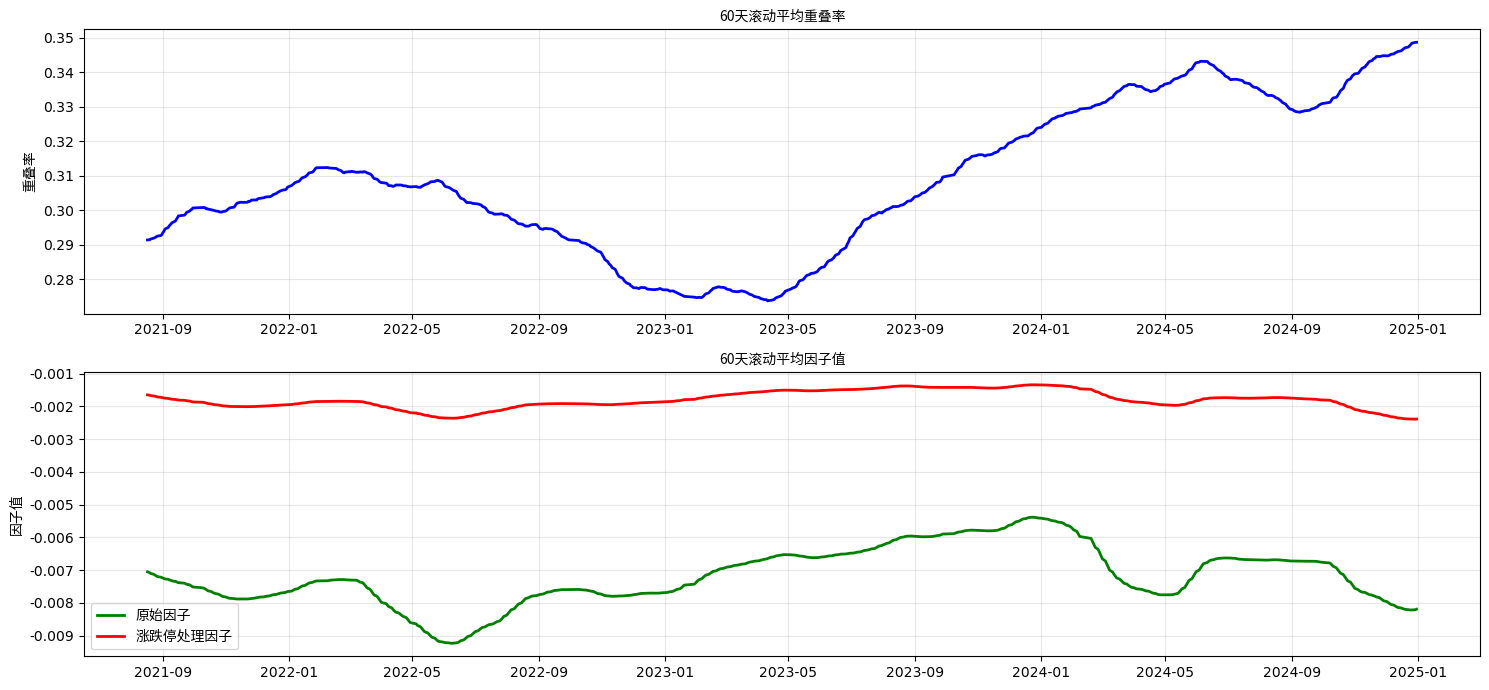

In [67]:
top_group_changes = analyze_top_group_characteristics(raw_factor, hl_raw_factor, std_factor, hl_std_factor)

原始因子描述性统计:
count    4127209.0
mean     -0.015687
std       0.082421
min      -4.804082
25%      -0.013538
50%      -0.010849
75%      -0.008831
max           -0.0
Name: bid_main_1000_1430, dtype: double[pyarrow]

涨跌停处理后因子描述性统计:
count    4127209.0
mean     -0.014772
std       0.081329
min      -4.804082
25%      -0.013342
50%      -0.010539
75%      -0.008313
max           -0.0
Name: hl_bid_main_1000_1430, dtype: double[pyarrow]

分位数比较:
1.0% 分位数 - 原始: -0.026698, 处理后: -0.026507, 差异: 0.000191
5.0% 分位数 - 原始: -0.019184, 处理后: -0.019047, 差异: 0.000137
10.0% 分位数 - 原始: -0.016720, 处理后: -0.016570, 差异: 0.000150
90.0% 分位数 - 原始: -0.007430, 处理后: -0.006241, 差异: 0.001189
95.0% 分位数 - 原始: -0.006728, 处理后: -0.000000, 差异: 0.006728
99.0% 分位数 - 原始: -0.005611, 处理后: -0.000000, 差异: 0.005611


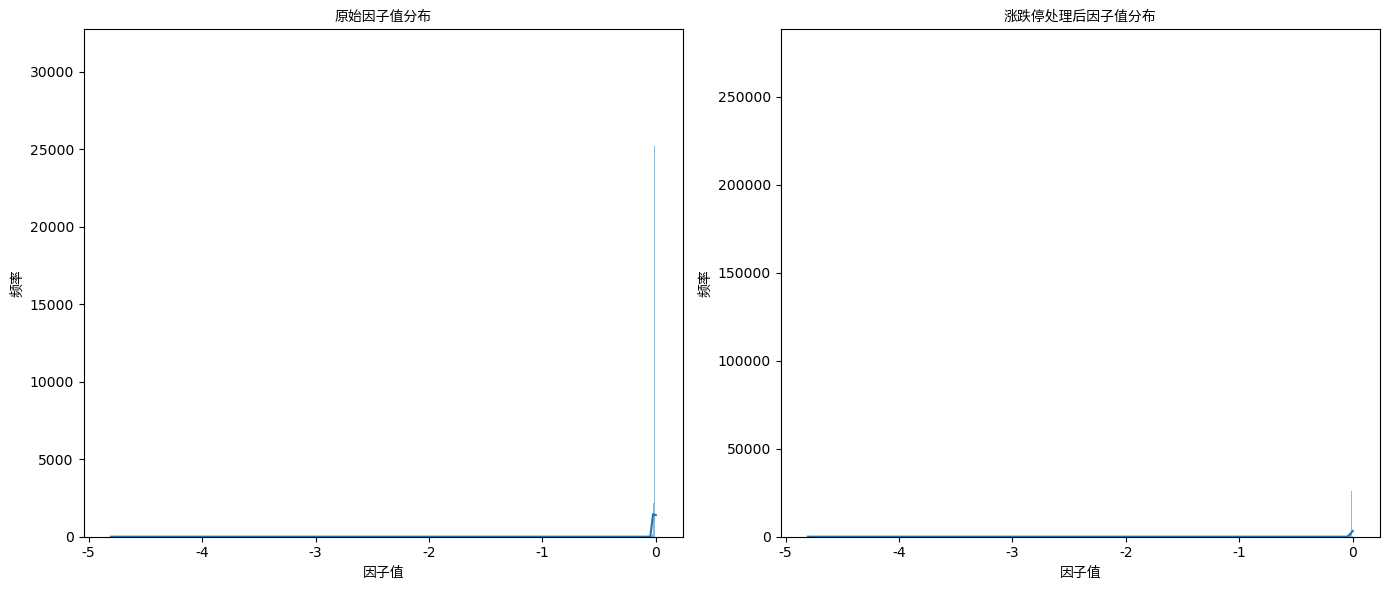

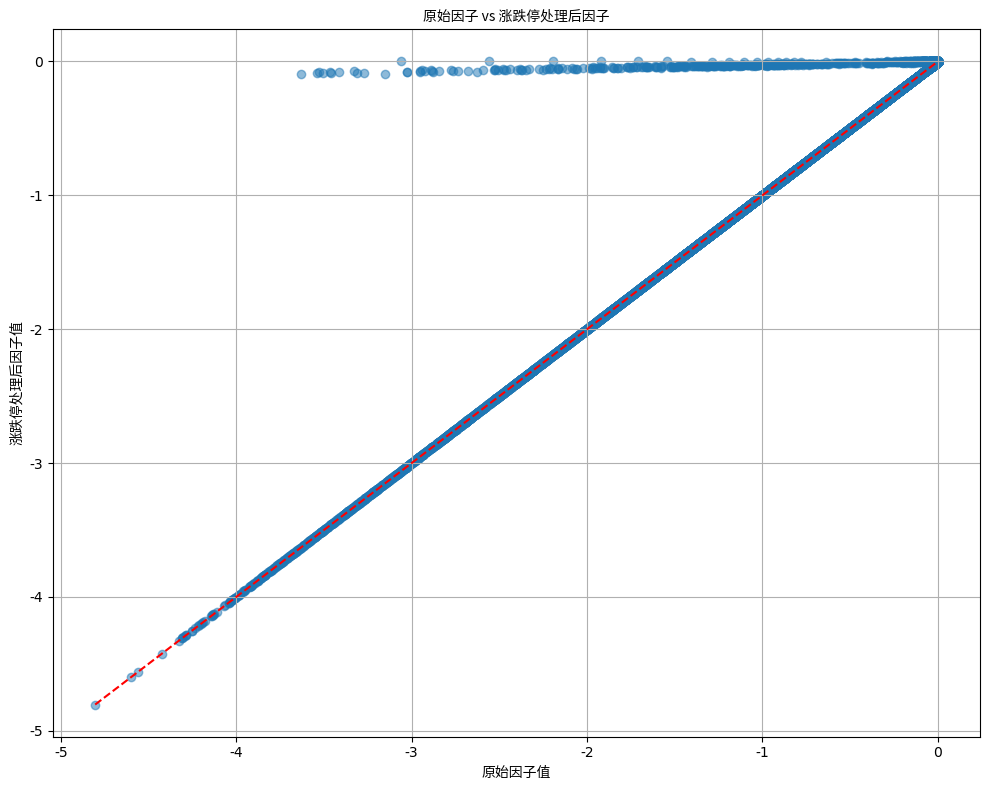

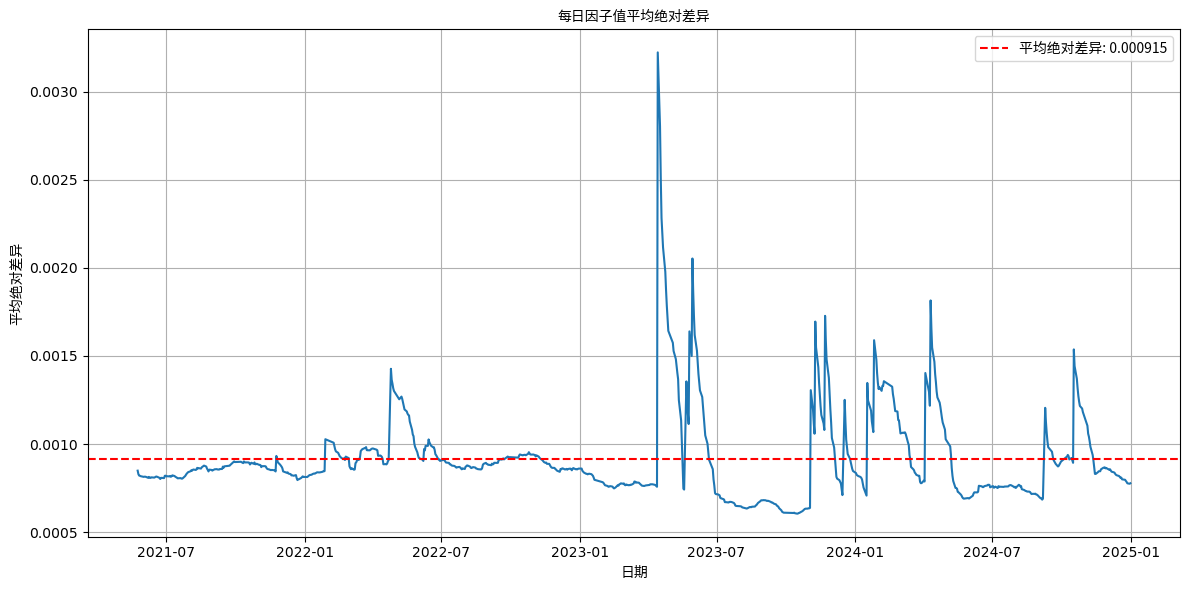

In [58]:
stats, factor_comparison = analyze_factor_distribution(raw_factor, hl_raw_factor)

In [20]:
def analyze_hl_factor_distribution(hl_raw_factor, hl_std_factor):
    """分析涨跌停处理前后因子值的分布变化"""
    # 合并因子数据
    merged = pd.merge(
        hl_raw_factor[['date', 'security_code', 'hl_bid_main_1000_1430']], 
        hl_std_factor[['date', 'security_code', 'hl_bid_main_1000_1430_std']], 
        on=['date', 'security_code'], 
        how='inner'
    )
    
    # 计算描述性统计量
    stats = {
        '涨跌停处理原始因子': merged['hl_bid_main_1000_1430'].describe(),
        '涨跌停处理标准化因子': merged['hl_bid_main_1000_1430_std'].describe()
    }
    
    print("涨跌停处理原始因子描述性统计:")
    print(stats['涨跌停处理原始因子'])
    print("\n涨跌停处理标准化因子描述性统计:")
    print(stats['涨跌停处理标准化因子'])
    
    # 绘制因子值分布图
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(merged['hl_bid_main_1000_1430'], kde=True)
    zh_title('涨跌停处理原始因子值分布')
    zh_xlabel('因子值')
    zh_ylabel('频率')
    
    plt.subplot(1, 2, 2)
    sns.histplot(merged['hl_bid_main_1000_1430_std'], kde=True)
    zh_title('涨跌停处理标准化因子值分布')
    zh_xlabel('因子值')
    zh_ylabel('频率')
    
    plt.tight_layout()
    
    # 绘制散点图比较原始因子和处理后因子
    plt.figure(figsize=(10, 8))
    plt.scatter(merged['hl_bid_main_1000_1430'], merged['hl_bid_main_1000_1430_std'], alpha=0.5)
    zh_xlabel('涨跌停处理原始因子值')
    zh_ylabel('涨跌停处理标准化因子值')
    zh_title('涨跌停处理原始因子 vs 标准化因子')
    plt.grid(True)
    
    # 添加对角线或趋势线（由于标准化后数据范围可能变化，可能需要拟合线而非对角线）
    # 如果需要对角线:
    min_val = min(merged['hl_bid_main_1000_1430'].min(), merged['hl_bid_main_1000_1430_std'].min())
    max_val = max(merged['hl_bid_main_1000_1430'].max(), merged['hl_bid_main_1000_1430_std'].max())
    # plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # 或者拟合线:
    from scipy import stats as spstats
    slope, intercept, r_value, p_value, std_err = spstats.linregress(
        merged['hl_bid_main_1000_1430'], merged['hl_bid_main_1000_1430_std']
    )
    x = np.array([min_val, max_val])
    plt.plot(x, intercept + slope*x, 'r--', 
             label=f'y = {slope:.4f}x + {intercept:.4f}, r² = {r_value**2:.4f}')
    zh_legend()
    
    plt.tight_layout()
    
    # 计算每日因子值差异的统计量
    merged['diff'] = merged['hl_bid_main_1000_1430_std'] - merged['hl_bid_main_1000_1430']
    
    daily_diff_stats = []
    for date in merged['date'].unique():
        date_data = merged[merged['date'] == date]
        daily_diff_stats.append({
            'date': date,
            'mean_diff': date_data['diff'].mean(),
            'abs_mean_diff': date_data['diff'].abs().mean(),
            'max_abs_diff': date_data['diff'].abs().max()
        })
    
    diff_stats_df = pd.DataFrame(daily_diff_stats)
    
    # 绘制每日平均差异变化图
    plt.figure(figsize=(12, 6))
    plt.plot(diff_stats_df['date'], diff_stats_df['abs_mean_diff'])
    plt.axhline(y=diff_stats_df['abs_mean_diff'].mean(), color='r', linestyle='--', 
                label=f'平均绝对差异: {diff_stats_df["abs_mean_diff"].mean():.6f}')
    zh_title('每日因子值平均绝对差异')
    zh_xlabel('日期')
    zh_ylabel('平均绝对差异')
    plt.grid(True)
    zh_legend()
    plt.tight_layout()
    
    # 检查极端值的变化
    percentiles = [0.01, 0.05, 0.1, 0.9, 0.95, 0.99]
    raw_percentiles = np.percentile(merged['hl_bid_main_1000_1430'], [p*100 for p in percentiles])
    std_percentiles = np.percentile(merged['hl_bid_main_1000_1430_std'], [p*100 for p in percentiles])
    
    print("\n分位数比较:")
    for i, p in enumerate(percentiles):
        print(f"{p*100}% 分位数 - 原始: {raw_percentiles[i]:.6f}, 标准化后: {std_percentiles[i]:.6f}, 差异: {std_percentiles[i] - raw_percentiles[i]:.6f}")
    
    # 添加异常点分析功能
    # 定义异常点的标准：偏离对角线较远的点
    merged['deviation'] = np.abs(merged['hl_bid_main_1000_1430_std'] - merged['hl_bid_main_1000_1430'])
    deviation_threshold = merged['deviation'].quantile(0.95)  # 取偏离度前5%的点作为异常点
    
    outliers = merged[merged['deviation'] > deviation_threshold]
    print(f"\n检测到 {len(outliers)} 个异常点 (偏离度 > {deviation_threshold:.6f})")
    
    # 绘制异常点突出显示的散点图
    plt.figure(figsize=(10, 8))
    plt.scatter(merged['hl_bid_main_1000_1430'], merged['hl_bid_main_1000_1430_std'], 
                alpha=0.3, label='正常点')
    plt.scatter(outliers['hl_bid_main_1000_1430'], outliers['hl_bid_main_1000_1430_std'], 
                color='red', alpha=0.7, label='异常点')
    zh_xlabel('涨跌停处理原始因子值')
    zh_ylabel('涨跌停处理标准化因子值')
    zh_title('异常点分析 - 偏离对角线的点')
    plt.grid(True)
    zh_legend()
    
    # 添加对角线
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.tight_layout()
    
    return stats, merged, outliers


涨跌停处理原始因子描述性统计:
count    4127209.0
mean     -0.014772
std       0.081329
min      -4.804082
25%      -0.013342
50%      -0.010539
75%      -0.008313
max           -0.0
Name: hl_bid_main_1000_1430, dtype: double[pyarrow]

涨跌停处理标准化因子描述性统计:
count    4.127209e+06
mean     2.818556e-03
std      9.978936e-01
min     -4.968627e+00
25%     -4.874390e-01
50%      5.883604e-02
75%      4.641450e-01
max      2.635250e+00
Name: hl_bid_main_1000_1430_std, dtype: float64


/tmp/ipykernel_2679230/1152519129.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()



分位数比较:
1.0% 分位数 - 原始: -0.026507, 标准化后: -3.076991, 差异: -3.050484
5.0% 分位数 - 原始: -0.019047, 标准化后: -1.624764, 差异: -1.605717
10.0% 分位数 - 原始: -0.016570, 标准化后: -1.122849, 差异: -1.106279
90.0% 分位数 - 原始: -0.006241, 标准化后: 0.849935, 差异: 0.856176
95.0% 分位数 - 原始: -0.000000, 标准化后: 2.208762, 差异: 2.208762
99.0% 分位数 - 原始: -0.000000, 标准化后: 2.451035, 差异: 2.451035

检测到 206361 个异常点 (偏离度 > 2.336832)


/tmp/ipykernel_2679230/1152519129.py:124: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


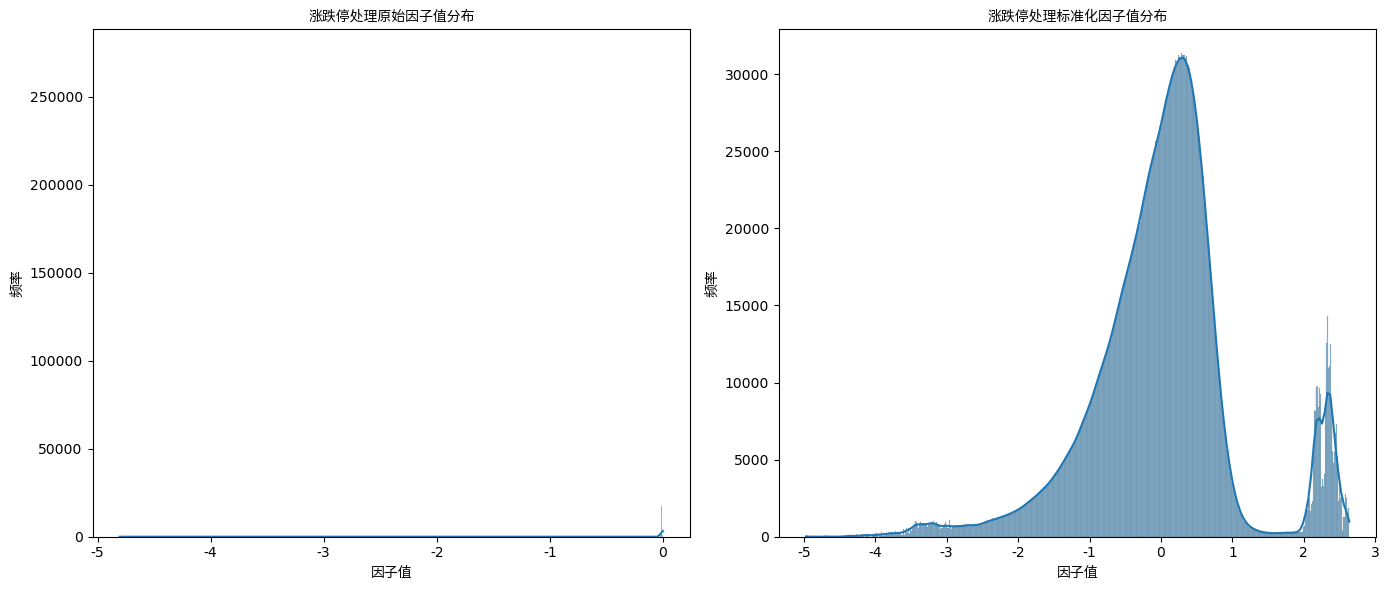

/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


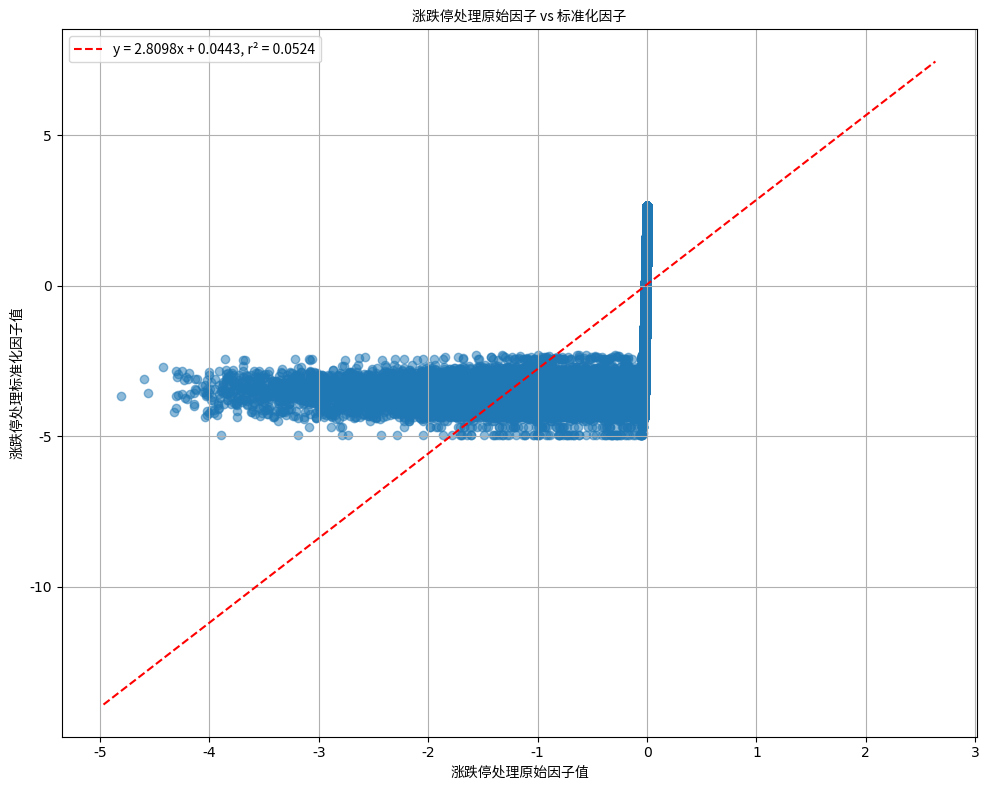

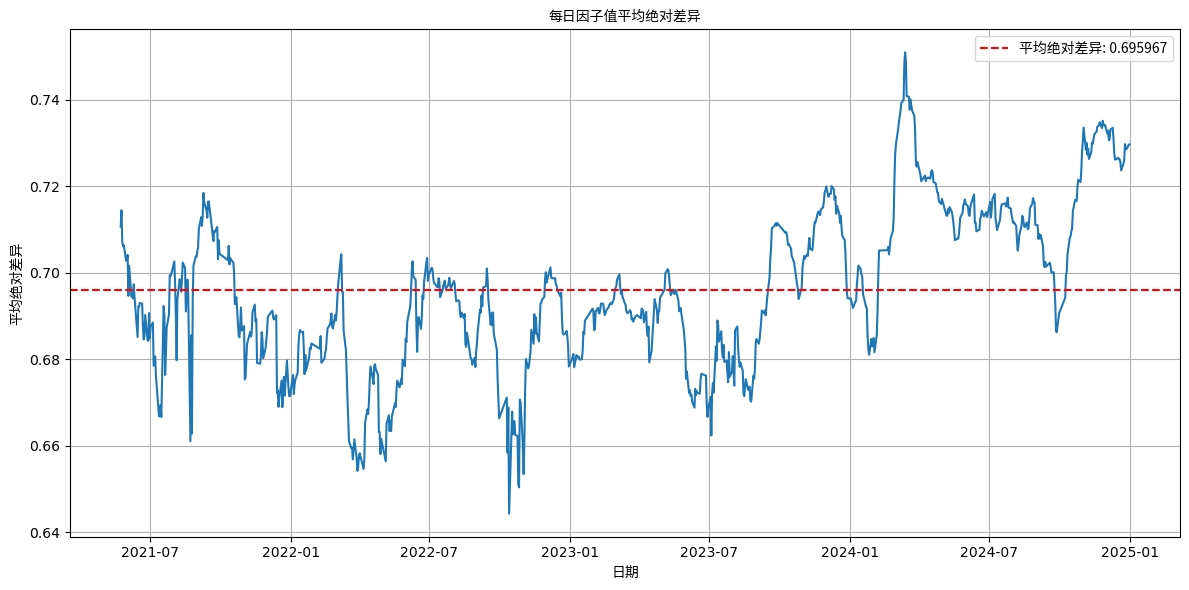

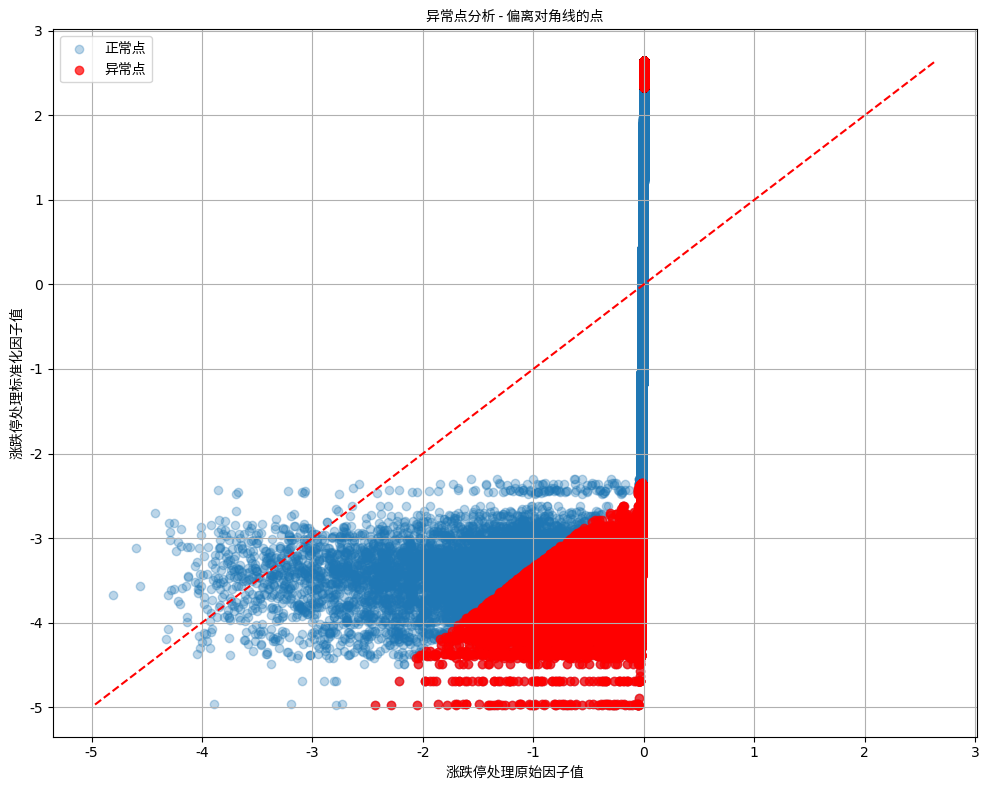

In [69]:
stats, merged, outliers = analyze_hl_factor_distribution(hl_raw_factor, hl_std_factor)

In [6]:
enlarge_raw_factor = raw_factor.copy()
enlarge_raw_factor['bid_main_1000_1430'] = enlarge_raw_factor['bid_main_1000_1430']*100

output_path = "/data/home/lexuanchen/Factors/Order/Signal/Six_Times_Divergence/Test"
os.makedirs(output_path, exist_ok=True)
output_file_path = f"{output_path}/Enlarge_100_bid_main_1000_1430.csv"

enlarge_raw_factor.to_csv(output_file_path,index=False)

In [7]:
enlarge_hl_raw_factor = hl_raw_factor.copy()
enlarge_hl_raw_factor['hl_bid_main_1000_1430'] = enlarge_hl_raw_factor['hl_bid_main_1000_1430']*100

output_path = "/data/home/lexuanchen/Factors/Order/Signal/Six_Times_Divergence/Test"
os.makedirs(output_path, exist_ok=True)
output_file_path = f"{output_path}/HL_Enlarge_100_bid_main_1000_1430.csv"

enlarge_hl_raw_factor.to_csv(output_file_path,index=False)

In [ ]:
lower_bound = np.percentile(enlarge_hl_raw_factor['hl_bid_main_1000_1430'], 0.5)  # 去除最小的0.5%
higher_bound = np.percentile(enlarge_hl_raw_factor['hl_bid_main_1000_1430'], 99.5)

mask = (enlarge_hl_raw_factor['hl_bid_main_1000_1430'] > lower_bound) & (enlarge_hl_raw_factor['hl_bid_main_1000_1430'] < higher_bound)
shrink_enlarge_hl_raw_factor = enlarge_hl_raw_factor.copy()
shrink_enlarge_hl_raw_factor.loc[~mask, 'hl_bid_main_1000_1430'] = np.nan  # 或其他替代值

output_file_path = f"{output_path}/HL_Shrink_Enlarge_100_bid_main_1000_1430.csv"

shrink_enlarge_hl_raw_factor.to_csv(output_file_path,index=False)

In [11]:
num_shrink_enlarge_hl_raw_factor = shrink_enlarge_hl_raw_factor.copy()
mask = (shrink_enlarge_hl_raw_factor['hl_bid_main_1000_1430'] < -0.15)
num_shrink_enlarge_hl_raw_factor.loc[~mask, 'hl_bid_main_1000_1430'] = np.nan  # 或其他替代值

output_file_path = f"{output_path}/HL_Num_Shrink_Enlarge_100_bid_main_1000_1430.csv"
num_shrink_enlarge_hl_raw_factor.to_csv(output_file_path,index=False)

In [12]:
lower_bound = np.percentile(enlarge_hl_raw_factor['hl_bid_main_1000_1430'], 0.5)  # 去除最小的0.5%
higher_bound = np.percentile(enlarge_hl_raw_factor['hl_bid_main_1000_1430'], 99.5)

Right_shrink_enlarge_hl_raw_factor = enlarge_hl_raw_factor.copy()
Left_shrink_enlarge_hl_raw_factor = enlarge_hl_raw_factor.copy()


right_mask =  (enlarge_hl_raw_factor['hl_bid_main_1000_1430'] < higher_bound)
Right_shrink_enlarge_hl_raw_factor.loc[~right_mask, 'hl_bid_main_1000_1430'] = np.nan  # 或其他替代值

left_mask = (enlarge_hl_raw_factor['hl_bid_main_1000_1430'] > lower_bound) 
Left_shrink_enlarge_hl_raw_factor.loc[~left_mask, 'hl_bid_main_1000_1430'] = np.nan  # 或其他替代值

r_output_file_path = f"{output_path}/HL_RightShrink_Enlarge_100_bid_main_1000_1430.csv"
l_output_file_path = f"{output_path}/HL_LeftShrink_Enlarge_100_bid_main_1000_1430.csv"

Right_shrink_enlarge_hl_raw_factor.to_csv(r_output_file_path,index=False)
Left_shrink_enlarge_hl_raw_factor.to_csv(l_output_file_path,index=False)

In [13]:
lower_bound = np.percentile(enlarge_raw_factor['bid_main_1000_1430'], 0.5)  # 去除最小的0.5%
higher_bound = np.percentile(enlarge_raw_factor['bid_main_1000_1430'], 99.5)

Right_shrink_enlarge_raw_factor = enlarge_raw_factor.copy()
Left_shrink_enlarge_raw_factor = enlarge_raw_factor.copy()


right_mask =  (enlarge_raw_factor['bid_main_1000_1430'] < higher_bound)
Right_shrink_enlarge_raw_factor.loc[~right_mask, 'bid_main_1000_1430'] = np.nan  # 或其他替代值

left_mask = (enlarge_raw_factor['bid_main_1000_1430'] > lower_bound) 
Left_shrink_enlarge_raw_factor.loc[~left_mask, 'bid_main_1000_1430'] = np.nan  # 或其他替代值

r_output_file_path = f"{output_path}/RightShrink_Enlarge_100_bid_main_1000_1430.csv"
l_output_file_path = f"{output_path}/LeftShrink_Enlarge_100_bid_main_1000_1430.csv"

Right_shrink_enlarge_raw_factor.to_csv(r_output_file_path,index=False)
Left_shrink_enlarge_raw_factor.to_csv(l_output_file_path,index=False)

In [8]:
output_path = "/data/home/lexuanchen/Factors/Order/Signal/Six_Times_Divergence/Test"

lower_bound = np.percentile(raw_factor['bid_main_1000_1430'], 0.5)  # 去除最小的0.5%
higher_bound = np.percentile(raw_factor['bid_main_1000_1430'], 99.5)

Right_shrink_raw_factor = raw_factor.copy()
Left_shrink_raw_factor = raw_factor.copy()


right_mask =  (raw_factor['bid_main_1000_1430'] < higher_bound)
Right_shrink_raw_factor.loc[~right_mask, 'bid_main_1000_1430'] = np.nan  # 或其他替代值

left_mask = (raw_factor['bid_main_1000_1430'] > lower_bound) 
Left_shrink_raw_factor.loc[~left_mask, 'bid_main_1000_1430'] = np.nan  # 或其他替代值

r_output_file_path = f"{output_path}/RightShrink_bid_main_1000_1430.csv"
l_output_file_path = f"{output_path}/LeftShrink_bid_main_1000_1430.csv"

Right_shrink_raw_factor.to_csv(r_output_file_path,index=False)
Left_shrink_raw_factor.to_csv(l_output_file_path,index=False)

In [23]:
limit_stocks = pd.read_parquet("/data/home/lexuanchen/.conda/envs/Order_Improvement/factors/limit_stocks_daily_1000_1430/all_limit_stocks.parquet")
limit_stocks['security_code'] = limit_stocks['security_code'].astype(str)

# 统一将日期转换为 'YYYY-MM-DD' 格式的字符串
limit_stocks['date'] = pd.to_datetime(limit_stocks['date']).dt.strftime('%Y-%m-%d')
raw_factor['date'] = pd.to_datetime(raw_factor['date']).dt.strftime('%Y-%m-%d')
std_factor['date'] = pd.to_datetime(std_factor['date']).dt.strftime('%Y-%m-%d')
hl_raw_factor['date'] = pd.to_datetime(hl_raw_factor['date']).dt.strftime('%Y-%m-%d')
hl_std_factor['date'] = pd.to_datetime(hl_std_factor['date']).dt.strftime('%Y-%m-%d')


raw_factor['security_code'] = raw_factor['security_code'].astype(str)
std_factor['security_code'] = std_factor['security_code'].astype(str)
hl_raw_factor['security_code'] = hl_raw_factor['security_code'].astype(str)
hl_std_factor['security_code'] = hl_std_factor['security_code'].astype(str)


In [ ]:
# 添加涨跌停标记到因子数据
def add_limit_flags(factor_df, limit_df):
    """将涨跌停标记添加到因子数据中"""
    merged_df = factor_df.merge(
        limit_df[['date', 'security_code', 'limit_label']],
        on=['date', 'security_code'],
        how='left'
    )
    
    # 添加涨跌停标志
    merged_df['is_limit'] = merged_df['limit_label'].notna()
    merged_df['is_upper_limit'] = merged_df['limit_label'] == 1
    merged_df['is_lower_limit'] = merged_df['limit_label'] == -1
    merged_df['is_both_limit'] = merged_df['limit_label'] == 0
    
    return merged_df

# 为每个因子添加涨跌停标记
raw_factor_with_limit = add_limit_flags(raw_factor, limit_stocks)
std_factor_with_limit = add_limit_flags(std_factor, limit_stocks)
hl_raw_factor_with_limit = add_limit_flags(hl_raw_factor, limit_stocks)
hl_std_factor_with_limit = add_limit_flags(hl_std_factor, limit_stocks)



In [32]:
l = [raw_factor_with_limit,std_factor_with_limit,hl_raw_factor_with_limit,hl_std_factor_with_limit]
for factor_df in l:
    factor_df['limit_label_str'] = factor_df['limit_label'].astype(str)
    factor_df.loc[factor_df['limit_label_str'] == 'nan', 'limit_label_str'] = '非涨跌停'

In [36]:
l = [raw_factor_with_limit,std_factor_with_limit,hl_raw_factor_with_limit,hl_std_factor_with_limit]
for factor_df in l:
    existing_categories = factor_df['limit_label_str'].dropna().unique().tolist()
    print(existing_categories)

['非涨跌停', '1.0', '-1.0', '0.0']
['非涨跌停', '1.0', '-1.0', '0.0']
['非涨跌停', '1.0', '-1.0', '0.0']
['非涨跌停', '1.0', '-1.0', '0.0']


/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 28072 (\N{CJK UNIFIED IDEOGRAPH-6DA8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 36300 (\N{CJK UNIFIED IDEOGRAPH-8DCC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 20572 (\N{CJK UNIFIED IDEOGRAPH-505C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/data/hom

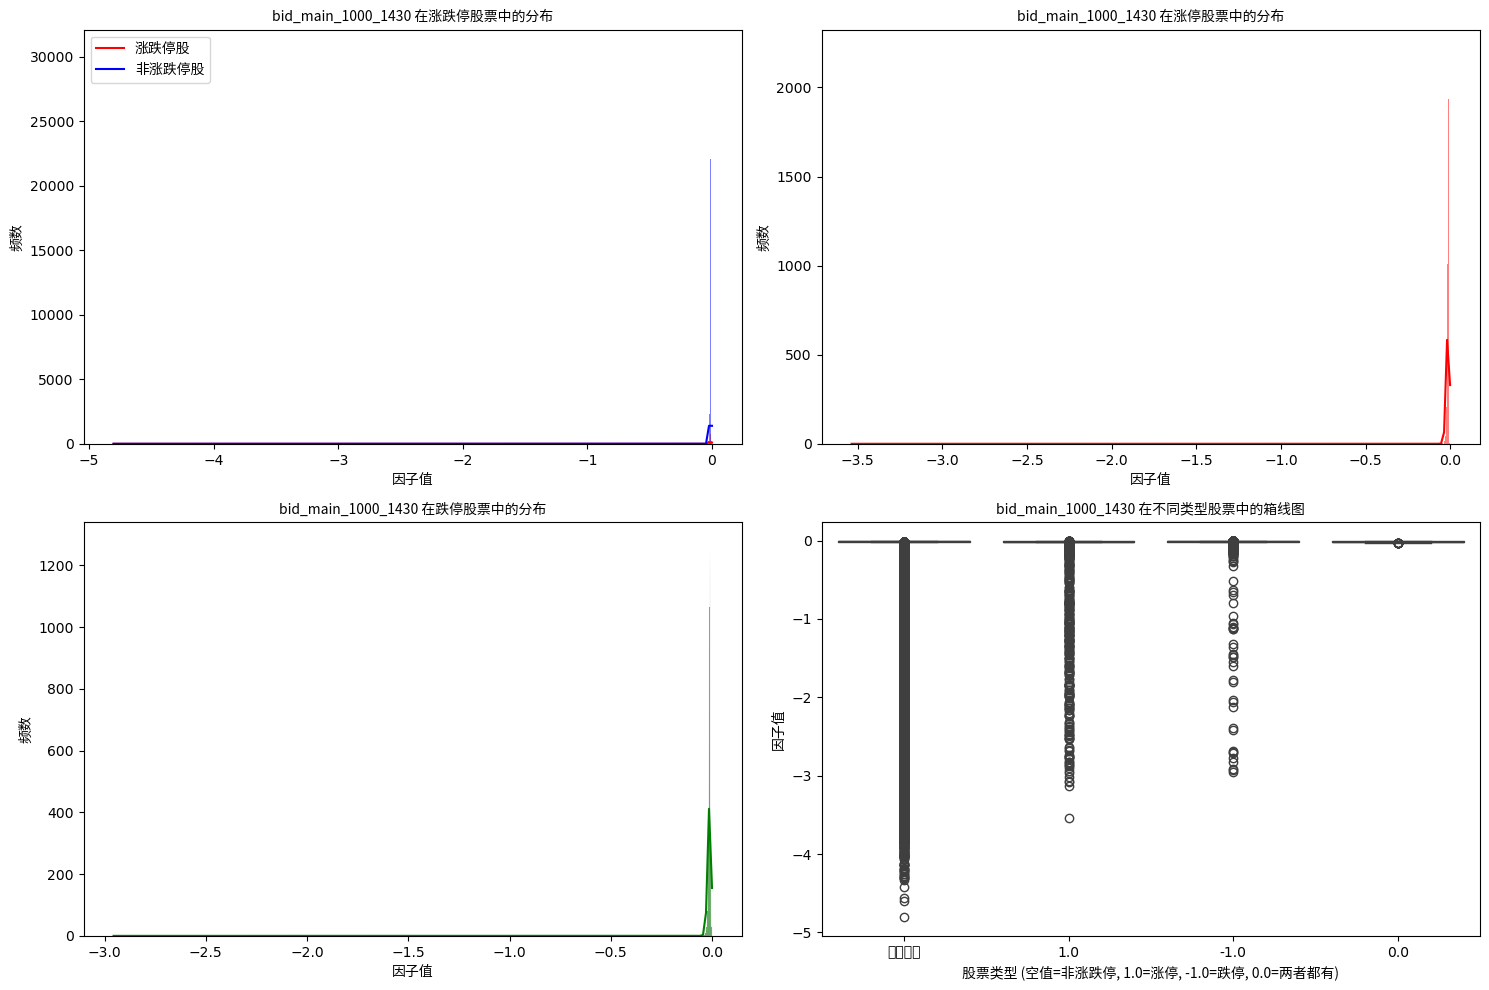

/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 28072 (\N{CJK UNIFIED IDEOGRAPH-6DA8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 36300 (\N{CJK UNIFIED IDEOGRAPH-8DCC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 20572 (\N{CJK UNIFIED IDEOGRAPH-505C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28072 (\N{CJK UNIFIED IDEOGRA

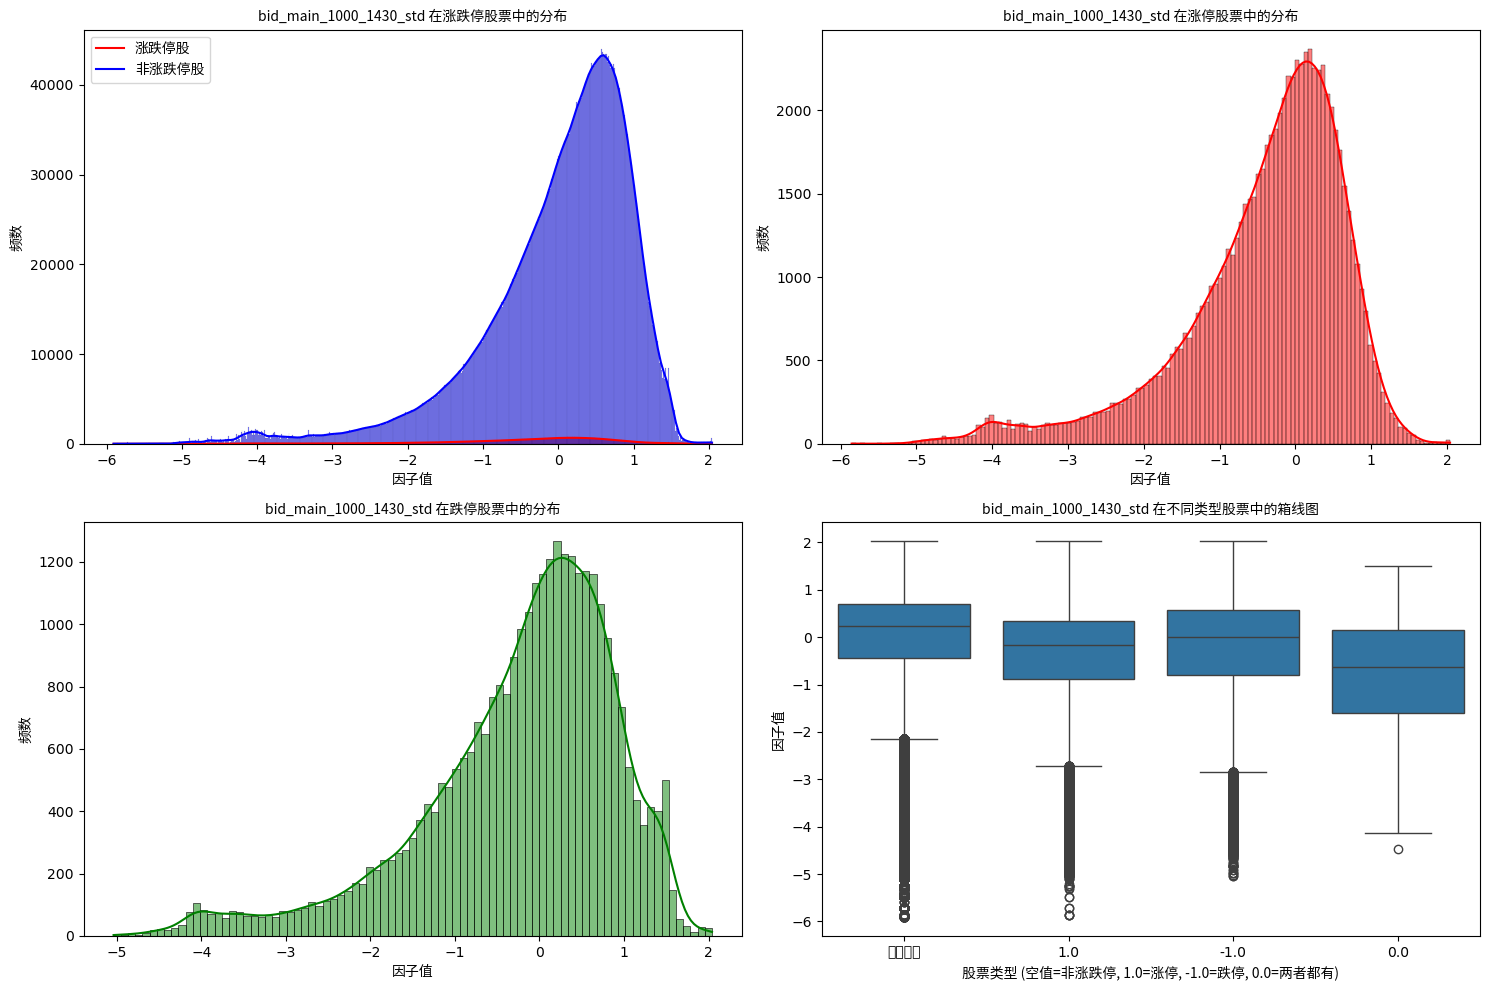

/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 28072 (\N{CJK UNIFIED IDEOGRAPH-6DA8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 36300 (\N{CJK UNIFIED IDEOGRAPH-8DCC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 20572 (\N{CJK UNIFIED IDEOGRAPH-505C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/data/hom

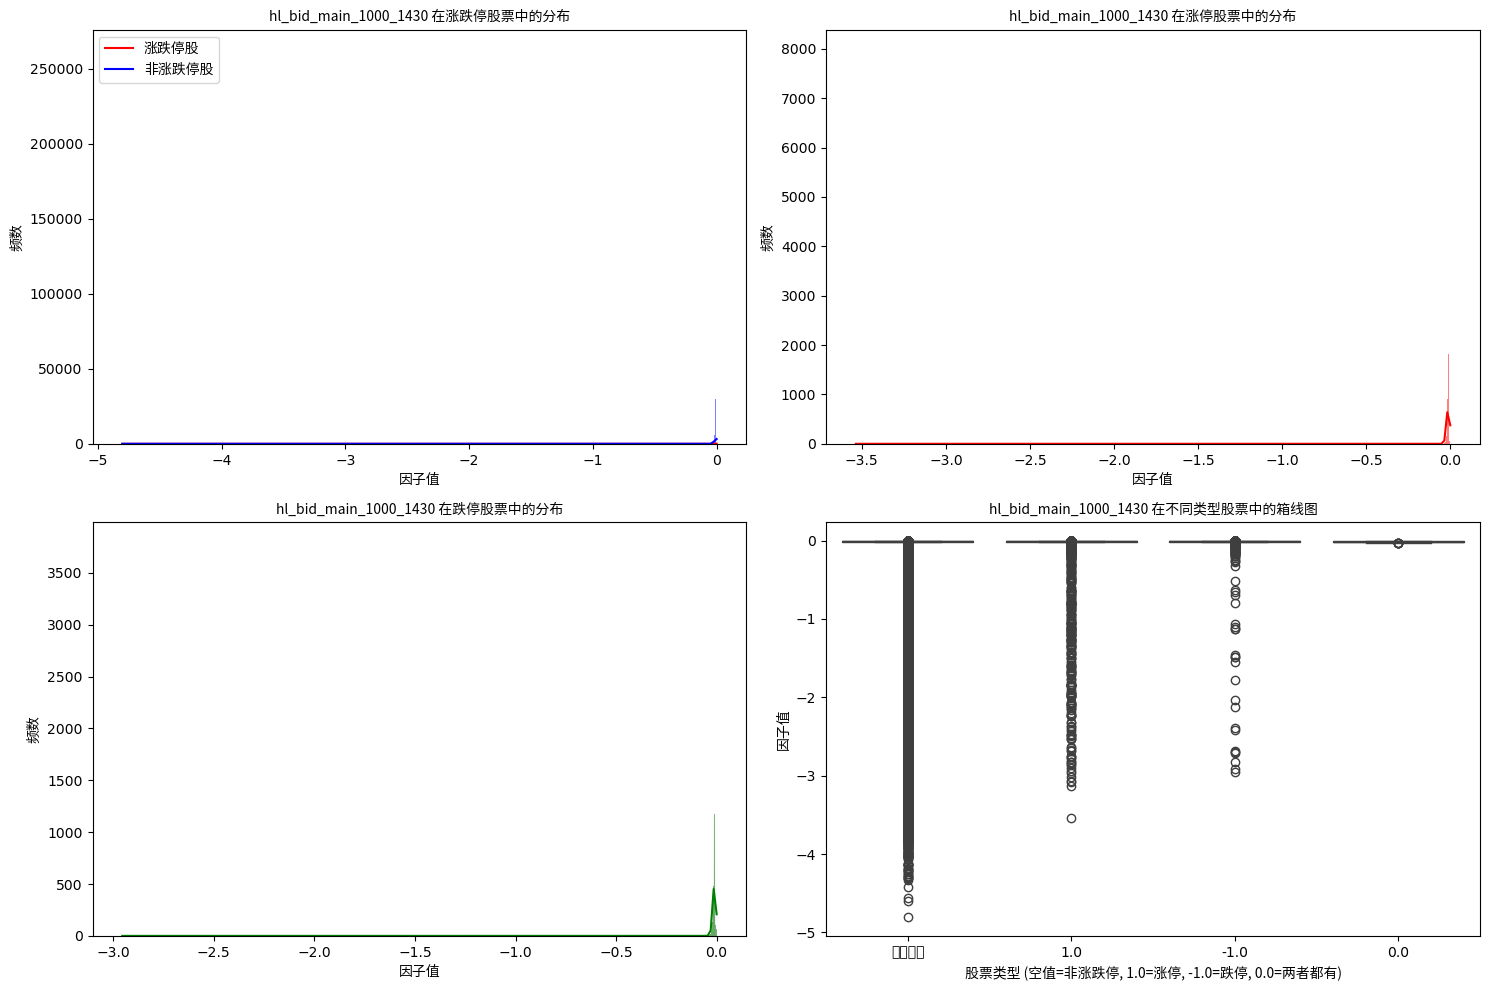

/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 28072 (\N{CJK UNIFIED IDEOGRAPH-6DA8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 36300 (\N{CJK UNIFIED IDEOGRAPH-8DCC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3486864/3759305887.py:36: UserWarning: Glyph 20572 (\N{CJK UNIFIED IDEOGRAPH-505C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38750 (\N{CJK UNIFIED IDEOGRAPH-975E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/home/lexuanchen/.conda/envs/test1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28072 (\N{CJK UNIFIED IDEOGRA

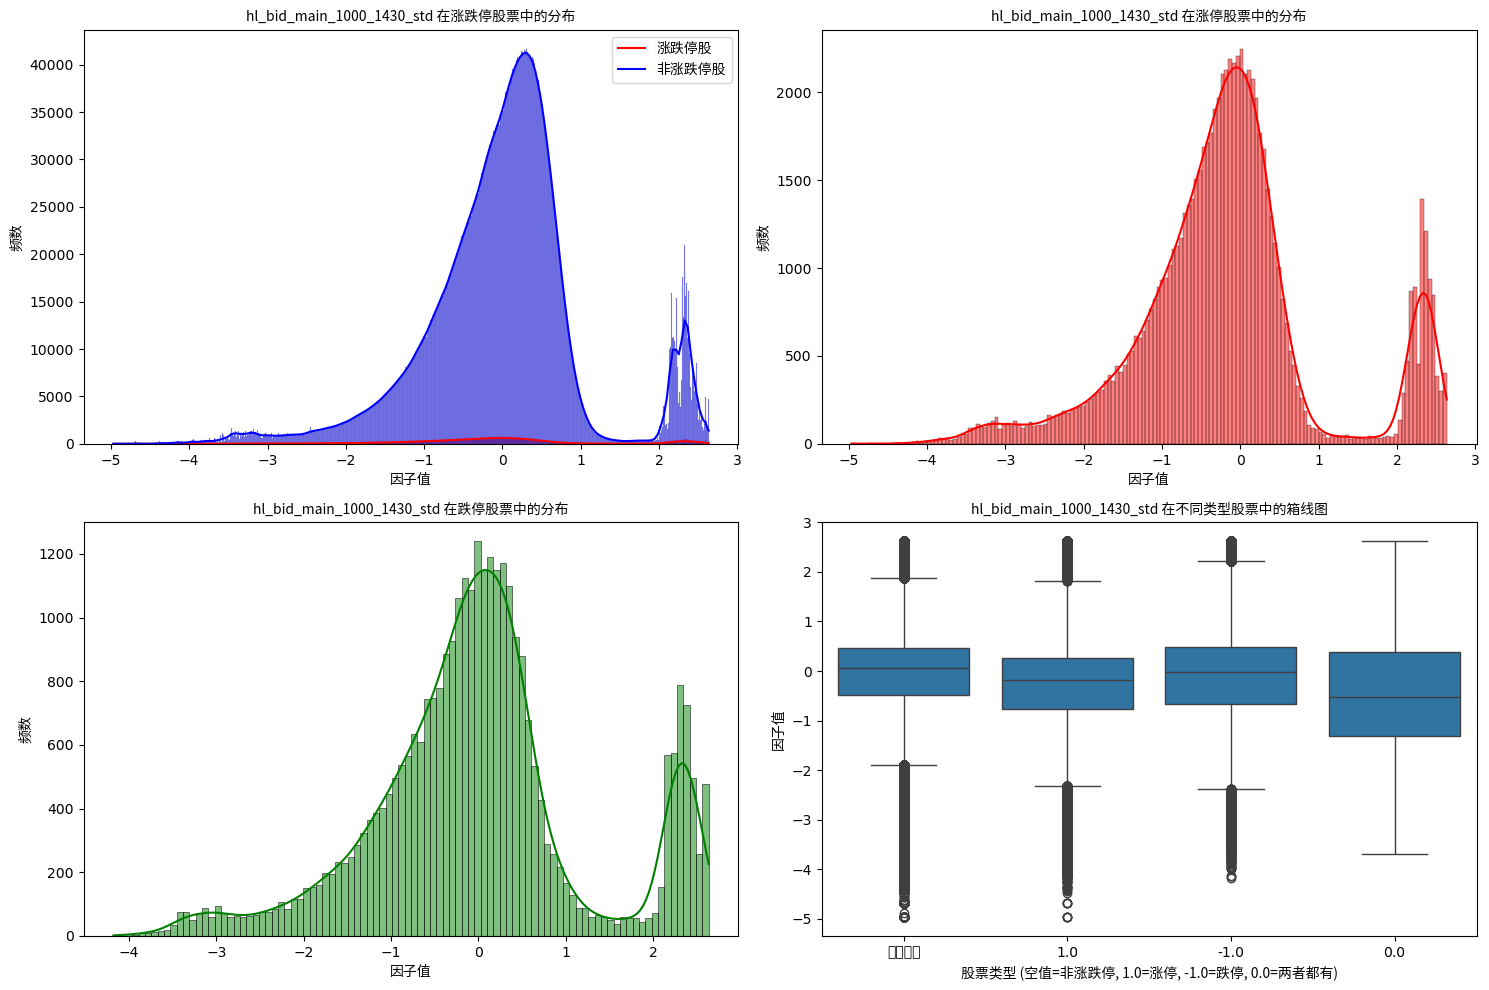

In [37]:
# 1. 分析 raw_factor 和 std_factor 中涨跌停股的分布情况
def analyze_factor_distribution(factor_df, factor_name, output_dir):
    """分析因子在涨跌停股票中的分布情况"""
    plt.figure(figsize=(15, 10))
    
    # 设置子图
    plt.subplot(2, 2, 1)
    sns.histplot(data=factor_df, x=factor_name, hue='is_limit', 
                 multiple='layer', kde=True, palette=['blue', 'red'])
    zh_title(f'{factor_name} 在涨跌停股票中的分布')
    zh_xlabel('因子值')
    zh_ylabel('频数')
    zh_legend(['涨跌停股', '非涨跌停股'])
    
    plt.subplot(2, 2, 2)
    sns.histplot(data=factor_df[factor_df['is_upper_limit']], x=factor_name, 
                 color='red', kde=True)
    zh_title(f'{factor_name} 在涨停股票中的分布')
    zh_xlabel('因子值')
    zh_ylabel('频数')
    
    plt.subplot(2, 2, 3)
    sns.histplot(data=factor_df[factor_df['is_lower_limit']], x=factor_name, 
                 color='green', kde=True)
    zh_title(f'{factor_name} 在跌停股票中的分布')
    zh_xlabel('因子值')
    zh_ylabel('频数')
    
    plt.subplot(2, 2, 4)
    sns.boxplot(data=factor_df, x='limit_label_str', y=factor_name, 
                order=['非涨跌停', '1.0', '-1.0', '0.0'])
    zh_title(f'{factor_name} 在不同类型股票中的箱线图')
    zh_xlabel('股票类型 (空值=非涨跌停, 1.0=涨停, -1.0=跌停, 0.0=两者都有)')
    zh_ylabel('因子值')
    
    plt.tight_layout()
    plt.show()
    
    # 计算统计数据
    stats = {
        '总样本数': len(factor_df),
        '涨跌停股票数': factor_df['is_limit'].sum(),
        '涨停股票数': factor_df['is_upper_limit'].sum(),
        '跌停股票数': factor_df['is_lower_limit'].sum(),
        '既涨停又跌停股票数': factor_df['is_both_limit'].sum(),
        '涨跌停股票占比': factor_df['is_limit'].mean() * 100,
        '非涨跌停股票因子均值': factor_df[~factor_df['is_limit']][factor_name].mean(),
        '涨跌停股票因子均值': factor_df[factor_df['is_limit']][factor_name].mean(),
        '涨停股票因子均值': factor_df[factor_df['is_upper_limit']][factor_name].mean(),
        '跌停股票因子均值': factor_df[factor_df['is_lower_limit']][factor_name].mean(),
        '非涨跌停股票因子中位数': factor_df[~factor_df['is_limit']][factor_name].median(),
        '涨跌停股票因子中位数': factor_df[factor_df['is_limit']][factor_name].median(),
        '涨停股票因子中位数': factor_df[factor_df['is_upper_limit']][factor_name].median(),
        '跌停股票因子中位数': factor_df[factor_df['is_lower_limit']][factor_name].median(),
    }
    
    return stats

# 分析每个因子的分布
raw_stats = analyze_factor_distribution(raw_factor_with_limit, 'bid_main_1000_1430', output_dir)
std_stats = analyze_factor_distribution(std_factor_with_limit, 'bid_main_1000_1430_std', output_dir)
hl_raw_stats = analyze_factor_distribution(hl_raw_factor_with_limit, 'hl_bid_main_1000_1430', output_dir)
hl_std_stats = analyze_factor_distribution(hl_std_factor_with_limit, 'hl_bid_main_1000_1430_std', output_dir)

# 将统计结果保存为CSV
stats_df = pd.DataFrame({
    '原始因子': raw_stats,
    '标准化因子': std_stats,
    'HL原始因子': hl_raw_stats,
    'HL标准化因子': hl_std_stats
})

stats_df.to_csv(f"{output_dir}/limit_stocks_factor_stats.csv")



In [31]:
# 检查涨跌停标记的分布
limit_counts = raw_factor_with_limit['is_limit'].value_counts()
print("涨跌停股票数量统计:")
print(f"涨跌停股票: {limit_counts.get(True, 0)}")
print(f"非涨跌停股票: {limit_counts.get(False, 0)}")
print(f"涨跌停比例: {limit_counts.get(True, 0) / (limit_counts.get(True, 0) + limit_counts.get(False, 0)) * 100:.2f}%")

# 检查图表绘制时的标签是否正确
# 在绘制图表时，确保正确标记涨跌停和非涨跌停的数据


涨跌停股票数量统计:
涨跌停股票: 108094
非涨跌停股票: 4019125
涨跌停比例: 2.62%


In [40]:
def analyze_top_group_changes(factor1_df, factor2_df, factor1_name, factor2_name, top_pct=0.1):
    """分析两个因子的多头端股票成分变化"""
    # 确保两个因子有相同的日期
    common_dates = sorted(set(factor1_df['date']) & set(factor2_df['date']))
    
    results = []
    
    for date in common_dates:
        # 获取当天的数据
        f1_day = factor1_df[factor1_df['date'] == date].copy()
        f2_day = factor2_df[factor2_df['date'] == date].copy()
        
        # 如果数据太少，跳过
        if len(f1_day) < 10 or len(f2_day) < 10:
            continue
        
        # 计算分位数阈值
        f1_threshold = f1_day[factor1_name].quantile(1 - top_pct)
        f2_threshold = f2_day[factor2_name].quantile(1 - top_pct)
        
        # 标记多头组股票
        f1_day['in_top_group'] = f1_day[factor1_name] >= f1_threshold
        f2_day['in_top_group'] = f2_day[factor2_name] >= f2_threshold
        
        # 合并两个因子的多头组信息
        merged = pd.merge(
            f1_day[['security_code', 'in_top_group', 'is_limit', 'is_upper_limit', 'is_lower_limit']],
            f2_day[['security_code', 'in_top_group']],
            on='security_code',
            how='outer',
            suffixes=('_f1', '_f2')
        )
        
        # 填充缺失值
        merged['in_top_group_f1'] = merged['in_top_group_f1'].fillna(False)
        merged['in_top_group_f2'] = merged['in_top_group_f2'].fillna(False)
        
        # 计算变化
        merged['status_change'] = 'unchanged'
        merged.loc[merged['in_top_group_f1'] & ~merged['in_top_group_f2'], 'status_change'] = 'exited'
        merged.loc[~merged['in_top_group_f1'] & merged['in_top_group_f2'], 'status_change'] = 'entered'
        
        # 统计涨跌停股票的变化
        limit_stats = {
            'date': date,
            'total_stocks': len(merged),
            'total_limit_stocks': merged['is_limit'].sum(),
            'total_upper_limit': merged['is_upper_limit'].sum(),
            'total_lower_limit': merged['is_lower_limit'].sum(),
            
            # 因子1多头组中的涨跌停股票
            'f1_top_group_size': merged['in_top_group_f1'].sum(),
            'f1_limit_in_top': merged[merged['in_top_group_f1']]['is_limit'].sum(),
            'f1_upper_in_top': merged[merged['in_top_group_f1']]['is_upper_limit'].sum(),
            'f1_lower_in_top': merged[merged['in_top_group_f1']]['is_lower_limit'].sum(),
            
            # 因子2多头组中的涨跌停股票
            'f2_top_group_size': merged['in_top_group_f2'].sum(),
            'f2_limit_in_top': merged[merged['in_top_group_f2']]['is_limit'].sum(),
            'f2_upper_in_top': merged[merged['in_top_group_f2']]['is_upper_limit'].sum(),
            'f2_lower_in_top': merged[merged['in_top_group_f2']]['is_lower_limit'].sum(),
            
            # 进入多头组的涨跌停股票
            'entered_count': (merged['status_change'] == 'entered').sum(),
            'limit_entered': merged[(merged['status_change'] == 'entered') & merged['is_limit']].shape[0],
            'upper_entered': merged[(merged['status_change'] == 'entered') & merged['is_upper_limit']].shape[0],
            'lower_entered': merged[(merged['status_change'] == 'entered') & merged['is_lower_limit']].shape[0],
            
            # 退出多头组的涨跌停股票
            'exited_count': (merged['status_change'] == 'exited').sum(),
            'limit_exited': merged[(merged['status_change'] == 'exited') & merged['is_limit']].shape[0],
            'upper_exited': merged[(merged['status_change'] == 'exited') & merged['is_upper_limit']].shape[0],
            'lower_exited': merged[(merged['status_change'] == 'exited') & merged['is_lower_limit']].shape[0],
        }
        
        results.append(limit_stats)
    
    # 转换为DataFrame
    results_df = pd.DataFrame(results)
    
    # 计算比例
    if not results_df.empty:
        # 计算各种比例
        results_df['f1_limit_ratio'] = results_df['f1_limit_in_top'] / results_df['f1_top_group_size']
        results_df['f2_limit_ratio'] = results_df['f2_limit_in_top'] / results_df['f2_top_group_size']
        results_df['entered_limit_ratio'] = results_df['limit_entered'] / results_df['entered_count'].replace(0, np.nan)
        results_df['exited_limit_ratio'] = results_df['limit_exited'] / results_df['exited_count'].replace(0, np.nan)
        
        # 可视化部分
        plt.figure(figsize=(20, 16))
        
        # 1. 多头组规模变化
        plt.subplot(3, 2, 1)
        plt.plot(results_df['date'], results_df['f1_top_group_size'], 'b-', label=f'{factor1_name} 多头组规模')
        plt.plot(results_df['date'], results_df['f2_top_group_size'], 'r-', label=f'{factor2_name} 多头组规模')
        zh_title('多头组规模变化')
        plt.xticks(rotation=45)
        zh_legend()
        plt.grid(True)
        
        # 2. 多头组中涨跌停股票数量
        plt.subplot(3, 2, 2)
        plt.plot(results_df['date'], results_df['f1_limit_in_top'], 'b-', label=f'{factor1_name} 多头组涨跌停数量')
        plt.plot(results_df['date'], results_df['f2_limit_in_top'], 'r-', label=f'{factor2_name} 多头组涨跌停数量')
        zh_title('多头组中涨跌停股票数量')
        plt.xticks(rotation=45)
        zh_legend()
        plt.grid(True)
        
        # 3. 多头组中涨跌停比例
        plt.subplot(3, 2, 3)
        plt.plot(results_df['date'], results_df['f1_limit_ratio'], 'b-', label=f'{factor1_name} 多头组涨跌停比例')
        plt.plot(results_df['date'], results_df['f2_limit_ratio'], 'r-', label=f'{factor2_name} 多头组涨跌停比例')
        zh_title('多头组中涨跌停股票比例')
        plt.xticks(rotation=45)
        zh_legend()
        plt.grid(True)
        
        # 4. 进入/退出多头组的股票数量
        plt.subplot(3, 2, 4)
        plt.plot(results_df['date'], results_df['entered_count'], 'g-', label='进入多头组的股票数量')
        plt.plot(results_df['date'], results_df['exited_count'], 'm-', label='退出多头组的股票数量')
        zh_title('多头组成分变化数量')
        plt.xticks(rotation=45)
        zh_legend()
        plt.grid(True)
        
        # 5. 进入/退出多头组的涨跌停股票数量
        plt.subplot(3, 2, 5)
        plt.plot(results_df['date'], results_df['limit_entered'], 'g-', label='进入多头组的涨跌停股票数量')
        plt.plot(results_df['date'], results_df['limit_exited'], 'm-', label='退出多头组的涨跌停股票数量')
        zh_title('多头组成分变化中的涨跌停股票数量')
        plt.xticks(rotation=45)
        zh_legend()
        plt.grid(True)
        
        # 6. 进入/退出多头组的涨跌停股票比例
        plt.subplot(3, 2, 6)
        plt.plot(results_df['date'], results_df['entered_limit_ratio'], 'g-', label='进入多头组的涨跌停股票比例')
        plt.plot(results_df['date'], results_df['exited_limit_ratio'], 'm-', label='退出多头组的涨跌停股票比例')
        zh_title('多头组成分变化中的涨跌停股票比例')
        plt.xticks(rotation=45)
        zh_legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # 额外创建涨停和跌停的单独图表
        plt.figure(figsize=(20, 12))
        
        # 1. 多头组中涨停股票数量
        plt.subplot(2, 2, 1)
        plt.plot(results_df['date'], results_df['f1_upper_in_top'], 'b-', label=f'{factor1_name} 多头组涨停数量')
        plt.plot(results_df['date'], results_df['f2_upper_in_top'], 'r-', label=f'{factor2_name} 多头组涨停数量')
        zh_title('多头组中涨停股票数量')
        plt.xticks(rotation=45)
        zh_legend()
        plt.grid(True)
        
        # 2. 多头组中跌停股票数量
        plt.subplot(2, 2, 2)
        plt.plot(results_df['date'], results_df['f1_lower_in_top'], 'b-', label=f'{factor1_name} 多头组跌停数量')
        plt.plot(results_df['date'], results_df['f2_lower_in_top'], 'r-', label=f'{factor2_name} 多头组跌停数量')
        zh_title('多头组中跌停股票数量')
        plt.xticks(rotation=45)
        zh_legend()
        plt.grid(True)
        
        # 3. 进入/退出多头组的涨停股票数量
        plt.subplot(2, 2, 3)
        plt.plot(results_df['date'], results_df['upper_entered'], 'g-', label='进入多头组的涨停股票数量')
        plt.plot(results_df['date'], results_df['upper_exited'], 'm-', label='退出多头组的涨停股票数量')
        zh_title('多头组成分变化中的涨停股票数量')
        plt.xticks(rotation=45)
        zh_legend()
        plt.grid(True)
        
        # 4. 进入/退出多头组的跌停股票数量
        plt.subplot(2, 2, 4)
        plt.plot(results_df['date'], results_df['lower_entered'], 'g-', label='进入多头组的跌停股票数量')
        plt.plot(results_df['date'], results_df['lower_exited'], 'm-', label='退出多头组的跌停股票数量')
        zh_title('多头组成分变化中的跌停股票数量')
        plt.xticks(rotation=45)
        zh_legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return results_df


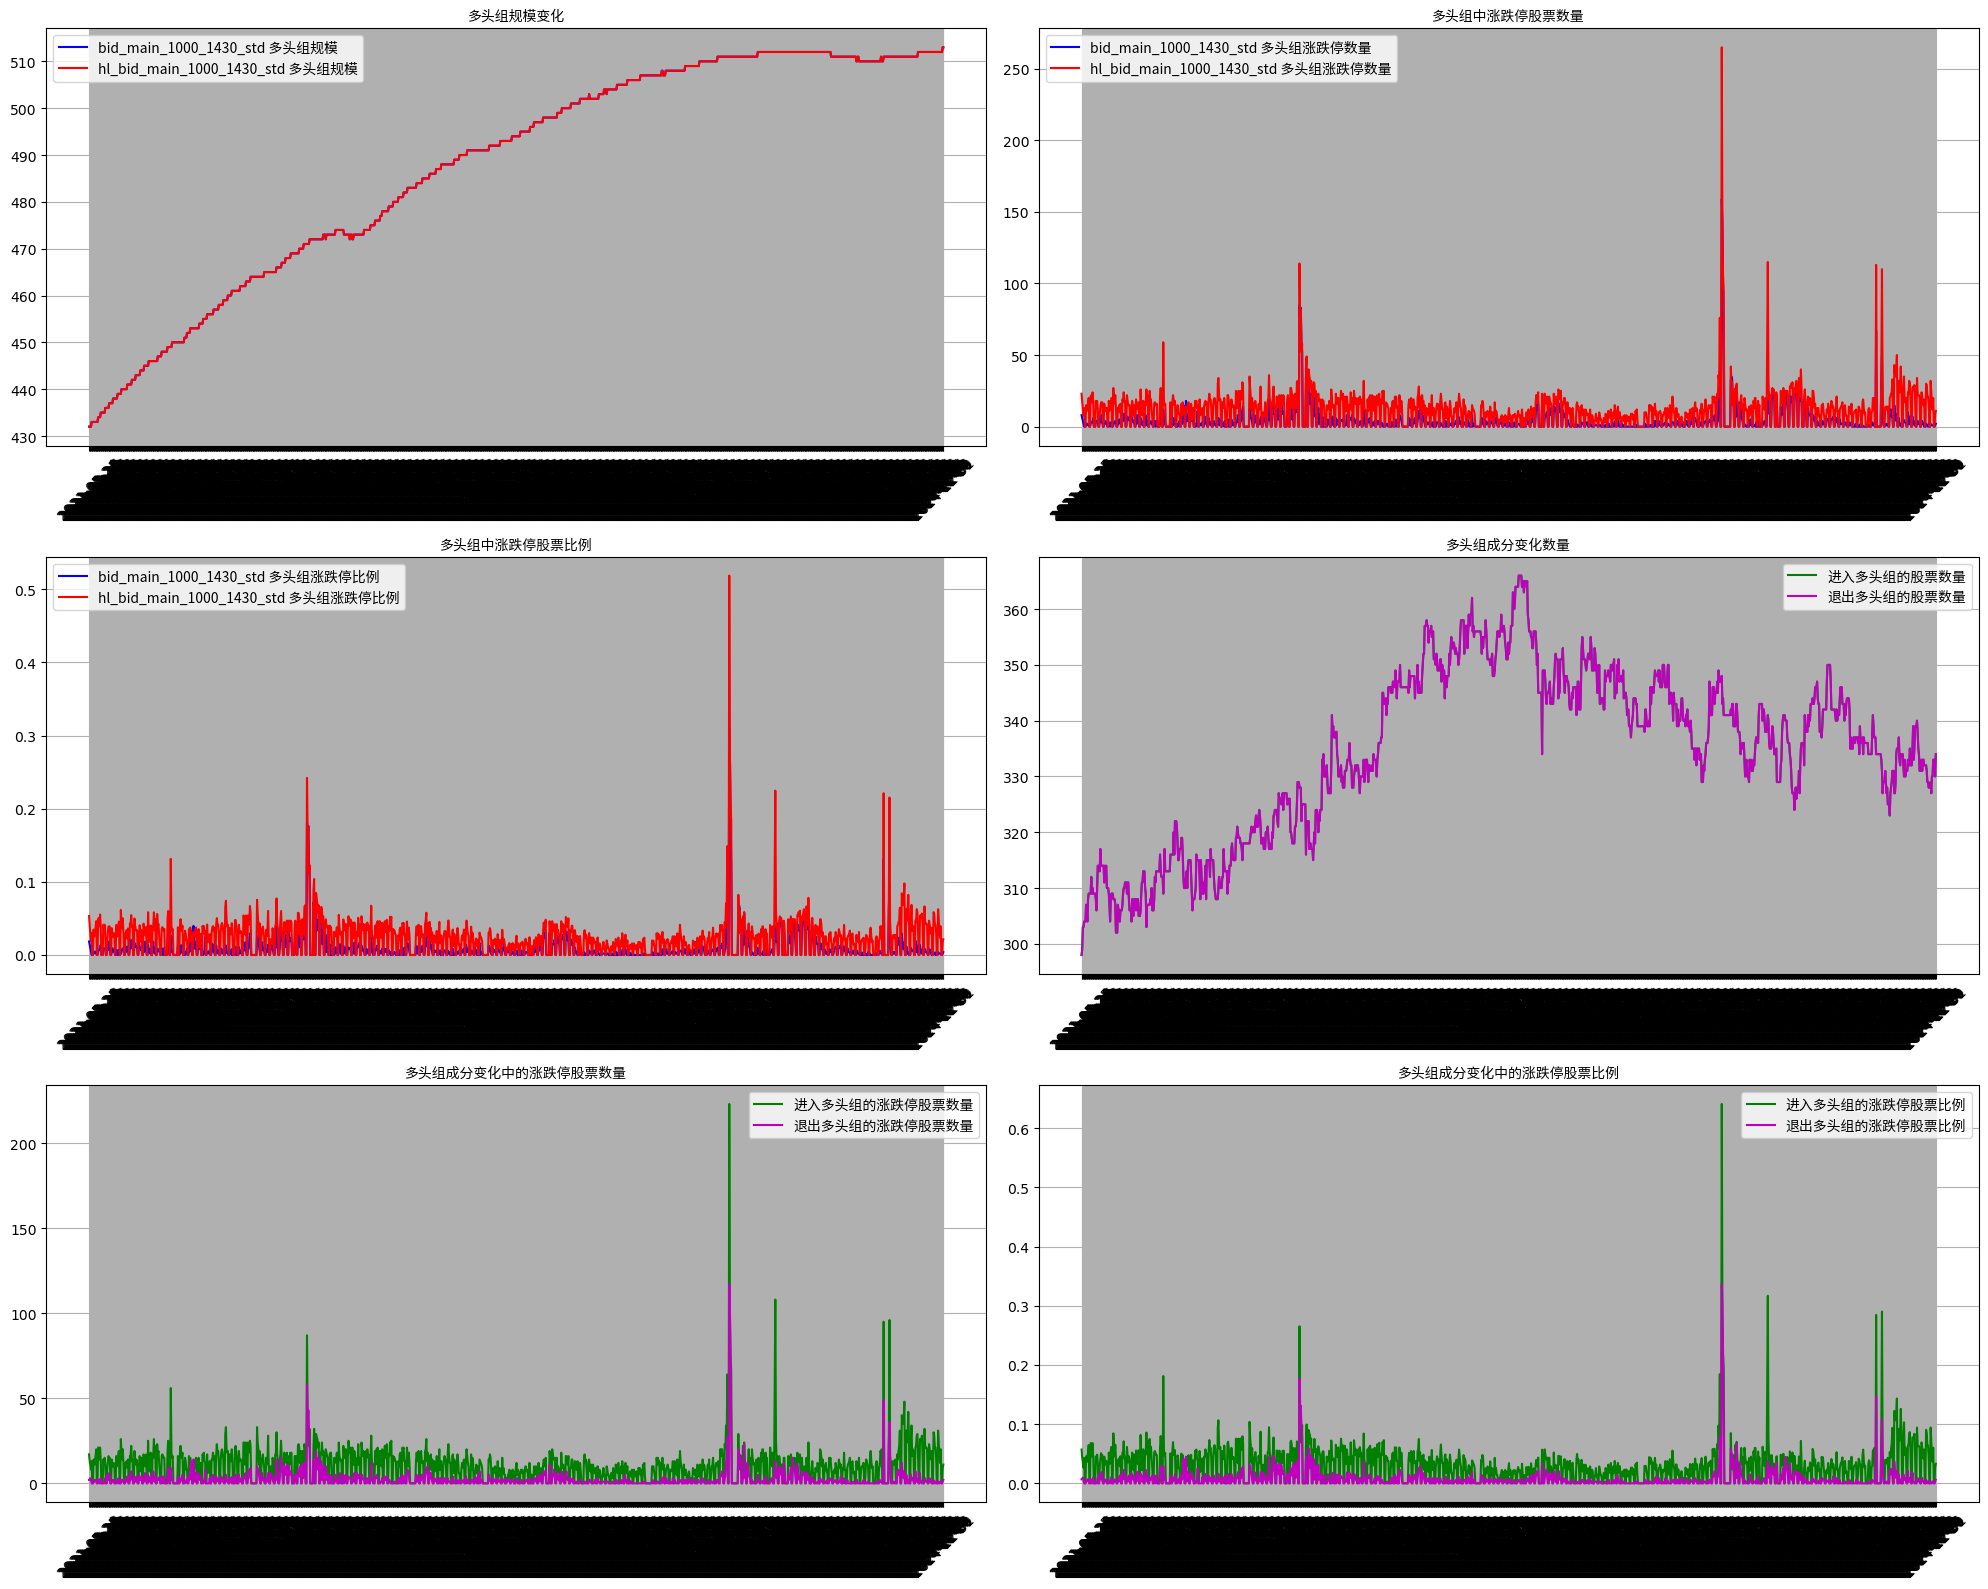

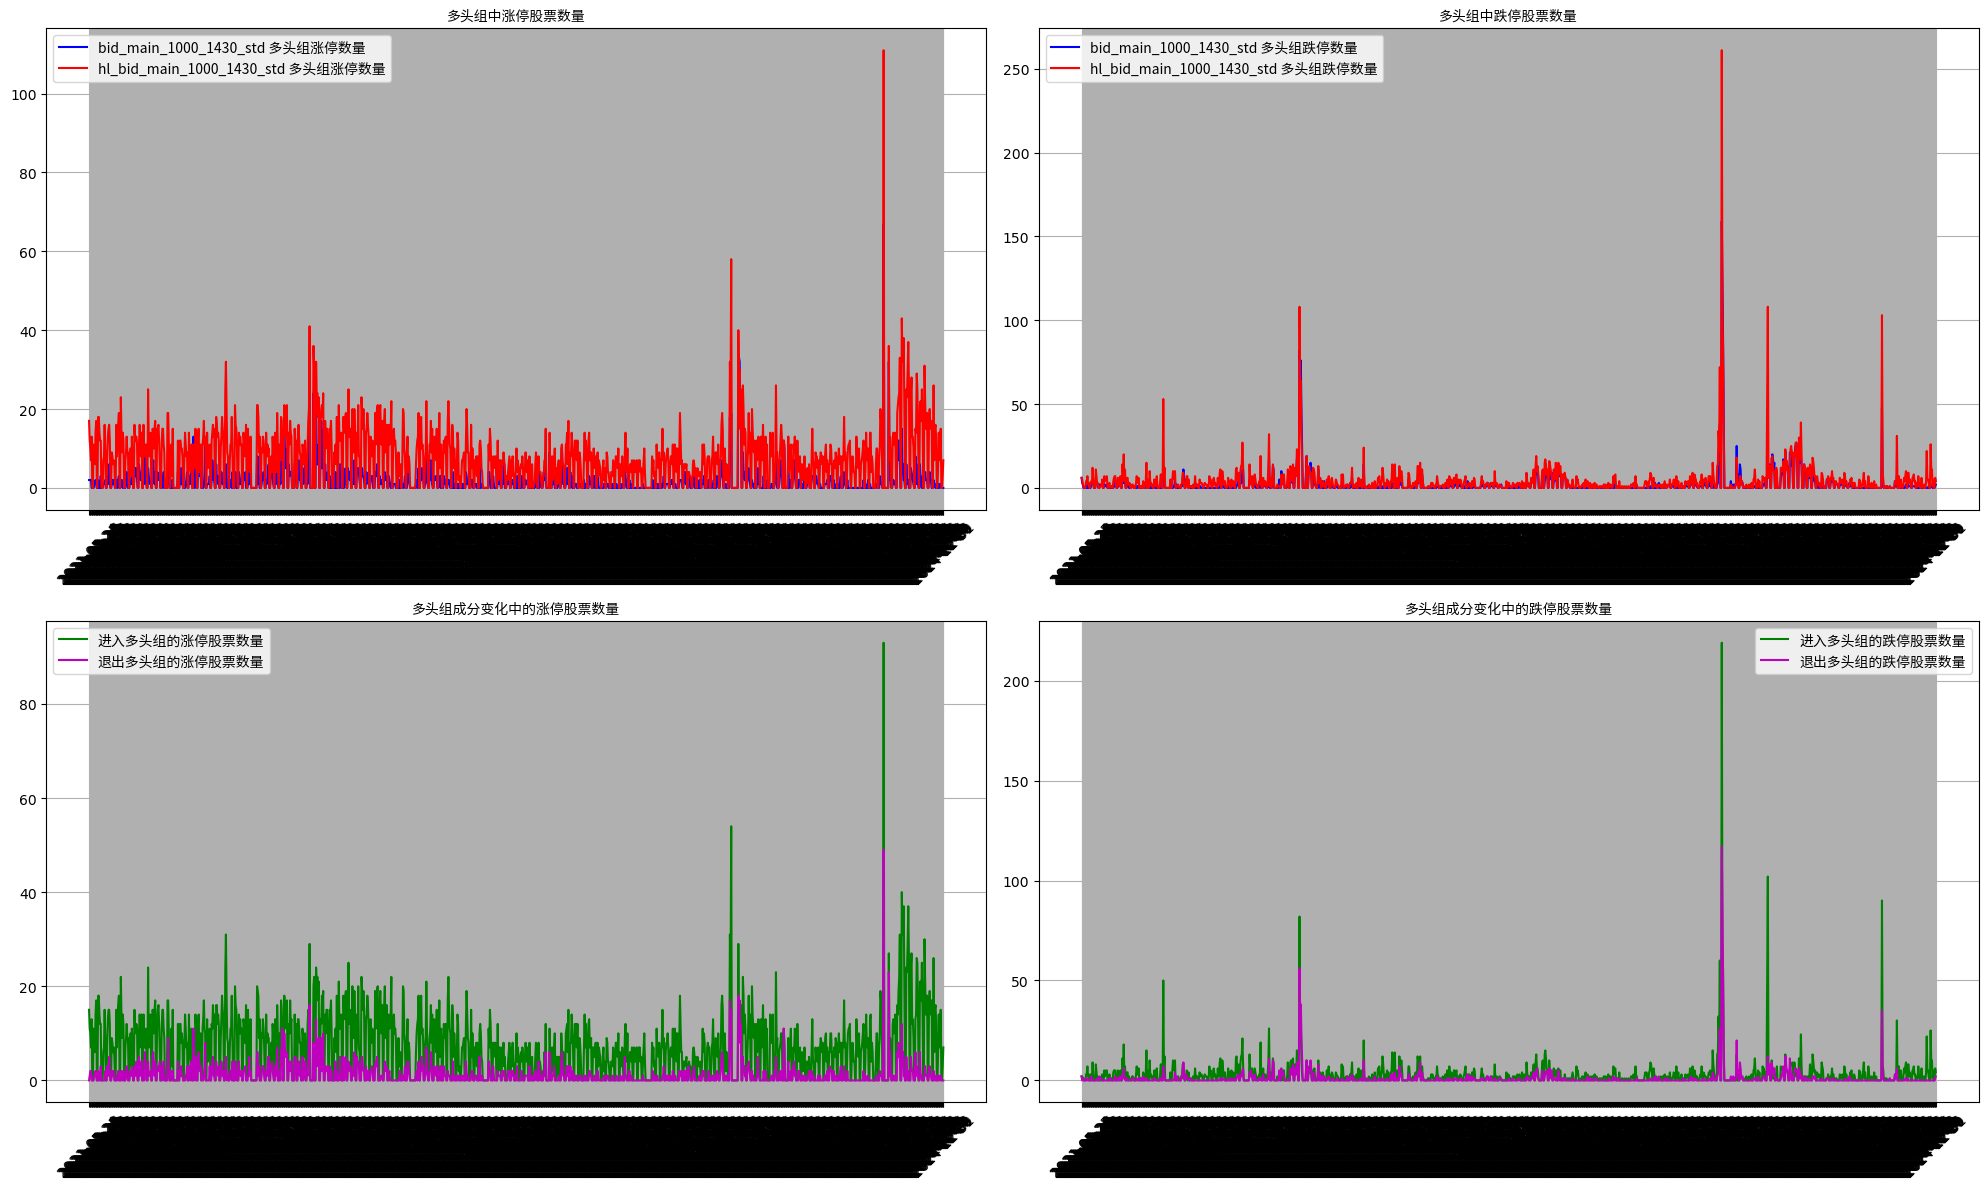

In [41]:
results_df = analyze_top_group_changes (std_factor_with_limit,hl_std_factor_with_limit, 'bid_main_1000_1430_std','hl_bid_main_1000_1430_std')

In [ ]:
# 额外添加一个对比各因子效果的总结图
def create_summary_comparison(raw_stats, std_stats, hl_raw_stats, hl_std_stats, output_dir):
    """创建一个总结图，比较各因子处理方法的效果"""
    
    plt.figure(figsize=(14, 10))
    
    # 准备数据
    factor_names = ['原始因子', '标准化因子', 'HL原始因子', 'HL标准化因子']
    metrics = pd.DataFrame({
        '因子': factor_names,
        '涨停股票平均百分位': [
            raw_stats['upper_limit_median'],
            std_stats['upper_limit_median'],
            hl_raw_stats['upper_limit_median'],
            hl_std_stats['upper_limit_median']
        ],
        '跌停股票平均百分位': [
            raw_stats['lower_limit_median'],
            std_stats['lower_limit_median'],
            hl_raw_stats['lower_limit_median'],
            hl_std_stats['lower_limit_median']
        ],
        '涨停Top10%占比': [
            raw_stats['upper_limit_top10_pct'],
            std_stats['upper_limit_top10_pct'],
            hl_raw_stats['upper_limit_top10_pct'],
            hl_std_stats['upper_limit_top10_pct']
        ],
        '跌停Bottom10%占比': [
            raw_stats['lower_limit_bottom10_pct'],
            std_stats['lower_limit_bottom10_pct'],
            hl_raw_stats['lower_limit_bottom10_pct'],
            hl_std_stats['lower_limit_bottom10_pct']
        ]
    })
    
    # 绘制条形图
    plt.subplot(2, 2, 1)
    sns.barplot(x='因子', y='涨停股票平均百分位', data=metrics, palette='Set2')
    zh_title('涨停股票平均百分位对比')
    zh_xlabel('因子类型')
    zh_ylabel('平均百分位')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    sns.barplot(x='因子', y='跌停股票平均百分位', data=metrics, palette='Set2')
    zh_title('跌停股票平均百分位对比')
    zh_xlabel('因子类型')
    zh_ylabel('平均百分位')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    sns.barplot(x='因子', y='涨停Top10%占比', data=metrics, palette='Set2')
    zh_title('涨停股票在Top10%中的占比')
    zh_xlabel('因子类型')
    zh_ylabel('占比 (%)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    sns.barplot(x='因子', y='跌停Bottom10%占比', data=metrics, palette='Set2')
    zh_title('跌停股票在Bottom10%中的占比')
    zh_xlabel('因子类型')
    zh_ylabel('占比 (%)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close()

# 调用总结比较函数
create_summary_comparison(raw_factor, std_factor, hl_raw_factor, hl_std_factor)